In [ ]:
!pip install torchvision

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
import pandas as pd
import os
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import numpy as np
import shutil
from tqdm import tqdm
import imghdr
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import models, datasets, transforms
from torch import nn, optim
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import seaborn as sns
from copy import deepcopy
#import optuna

# Preparing Data

In [ ]:
#!unzip "/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/archive (4).zip" -d "/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata"
#one time code used to unzip the data

In [ ]:
# Load the full dataset
diamond_df = pd.read_csv('/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/web_scraped/diamond_data.csv')

#drop a few broken image
diamond_df = diamond_df.loc[-diamond_df['stock_number'].isin(['220376-42', '220188-630'])]

In [ ]:
# Provided cut categories
valid_cuts = {'EX', 'VG', 'GD', 'FG', 'F', 'IDEAL'}

# Filter the DataFrame to display rows with cuts not in the valid_cuts set
invalid_cut_rows = diamond_df[~diamond_df['cut'].isin(valid_cuts)]

# Display these rows
print(invalid_cut_rows)

                           path_to_img stock_number    shape  carat clarity  \
5498   web_scraped/emerald/1016307.jpg      1016307  emerald   0.74     SI1   
5600   web_scraped/emerald/1016770.jpg      1016770  emerald   0.71     SI1   
5624   web_scraped/emerald/1016309.jpg      1016309  emerald   0.80     SI1   
5706   web_scraped/emerald/1012355.jpg      1012355  emerald   0.70     SI1   
6170   web_scraped/emerald/1002342.jpg      1002342  emerald   0.81     SI1   
...                                ...          ...      ...    ...     ...   
21665     web_scraped/pear/1025040.jpg      1025040     pear   0.90    VVS2   
21680     web_scraped/pear/1025531.jpg      1025531     pear   0.91    VVS2   
21681     web_scraped/pear/1024566.jpg      1024566     pear   0.91    VVS2   
21682     web_scraped/pear/1024280.jpg      1024280     pear   0.91    VVS2   
21823     web_scraped/pear/1025454.jpg      1025454     pear   0.90    VVS1   

      colour  cut polish symmetry fluorescence  lab

In [ ]:
#remove image that does have cut recorded
diamond_valid_df = diamond_df[diamond_df['cut'].isin(valid_cuts)]

diamond_valid_df['cut'].value_counts()

EX       34060
VG       10380
GD        2786
FG         406
F           70
IDEAL       46
Name: cut, dtype: int64

In [ ]:
def map_cut_groups(cut):
    if cut in ['EX', 'IDEAL']:
        return 'High Quality'
    elif cut == 'VG':
        return 'Medium Quality'
    else:
        return 'Lower Quality'

# To deal with imbalance
diamond_valid_df['cut_group'] = diamond_valid_df['cut'].apply(map_cut_groups)

<ipython-input-7-61f6420a0706>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diamond_valid_df['cut_group'] = diamond_valid_df['cut'].apply(map_cut_groups)


In [ ]:
diamond_valid_df['cut_group'].value_counts()

High Quality      34106
Medium Quality    10380
Lower Quality      3262
Name: cut_group, dtype: int64

In [ ]:
# Function to create directories and move files
def create_and_move_files(sub_df, root_dir, subset_name):
    for index, row in tqdm(sub_df.iterrows(), total=sub_df.shape[0], desc=f"Processing {subset_name}"):
        img_path = row['path_to_img']
        cut = row['cut_group']

        # Check and handle invalid image path
        if not isinstance(img_path, str):
            print(f"Invalid path at index {index}: {img_path}")
            continue

        # Check and handle invalid cut value
        if not isinstance(cut, str):
            cut = str(cut)  # Convert to string or handle differently if needed
            if cut == 'nan':
                print(f"Invalid cut at index {index}: {cut}")
                continue

        file_path = os.path.join(root_dir, img_path)
        if os.path.exists(file_path):
            cut_dir = os.path.join(root_dir, subset_name, cut)
            os.makedirs(cut_dir, exist_ok=True)
            shutil.move(file_path, os.path.join(cut_dir, os.path.basename(file_path)))
        sub_df.at[index, 'folder'] = subset_name

In [ ]:
# Define the directory containing the images
root_dir = '/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/'

# Split the data
train_df, test_df = train_test_split(diamond_valid_df, test_size=0.3,stratify=diamond_valid_df['cut_group'], random_state=249)
valid_df, test_df = train_test_split(test_df, test_size=1/3, stratify=test_df['cut_group'], random_state=249)  # 0.2 of the total data

# Create directories and move files
create_and_move_files(train_df, root_dir, 'train')
create_and_move_files(valid_df, root_dir, 'valid')
create_and_move_files(test_df, root_dir, 'test')

# Combine the dataframes back and save to a new CSV
combined_df = pd.concat([train_df, valid_df, test_df])
combined_df.to_csv('/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/updated_diamond_data.csv', index=False)

Processing test: 100%|██████████| 4775/4775 [00:10<00:00, 439.15it/s]


In [ ]:
def image_size_frequency(directory):
    size_freq = Counter()

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    with Image.open(os.path.join(root, file)) as img:
                        size = img.size  # (width, height)
                        size_freq[size] += 1
                except IOError:
                    print(f"Cannot open {file}")

    return size_freq

In [ ]:
#don't run again
# Directory path
base_dir = '/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata'

# Call the function and print the results
size_frequency = image_size_frequency(base_dir)
for size, freq in size_frequency.items():
    print(f"Size {size}: Frequency = {freq}")

Cannot open 220188-630.jpg
Size (600, 471): Frequency = 6120
Size (577, 454): Frequency = 737
Size (600, 474): Frequency = 9362
Size (600, 475): Frequency = 4540
Size (600, 473): Frequency = 5784
Size (600, 472): Frequency = 9451
Size (591, 467): Frequency = 529
Size (523, 411): Frequency = 217
Size (569, 450): Frequency = 147
Size (601, 475): Frequency = 83
Size (589, 463): Frequency = 49
Size (567, 444): Frequency = 623
Size (499, 391): Frequency = 731
Size (518, 405): Frequency = 430
Size (589, 461): Frequency = 31
Size (566, 445): Frequency = 1333
Size (597, 469): Frequency = 619
Size (548, 432): Frequency = 17
Size (549, 432): Frequency = 3
Size (553, 437): Frequency = 61
Size (493, 390): Frequency = 411
Size (559, 442): Frequency = 41
Size (504, 398): Frequency = 51
Size (557, 437): Frequency = 15
Size (579, 454): Frequency = 629
Size (515, 402): Frequency = 121
Size (579, 458): Frequency = 8
Size (587, 460): Frequency = 855
Size (567, 449): Frequency = 112
Size (534, 419): Frequ

# Explore Data

In [ ]:
full_data_df = pd.read_csv('/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/updated_diamond_data.csv')

In [ ]:
full_data_df[full_data_df['folder'] == 'valid']['cut_group'].value_counts()

High Quality      6821
Medium Quality    2076
Lower Quality      653
Name: cut_group, dtype: int64

In [ ]:
len(full_data_df[full_data_df['folder'] == 'valid'])

9550

# Dataloader

In [ ]:
# Define your transformations, you may need to adjust the normalization values
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create ImageFolder datasets
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/train', transform=transform)
valid_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/valid', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/test', transform=transform)
'''train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Final Project/Final Project/newdata/train', transform=transform)
valid_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Final Project/Final Project/newdata/valid', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Final Project/Final Project/newdata/test', transform=transform)'''

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

data_loaders = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

In [ ]:
print(len(data_loaders['train'].dataset))
print(len(data_loaders['valid'].dataset))
print(len(data_loaders['test'].dataset))

14554
4227
2098


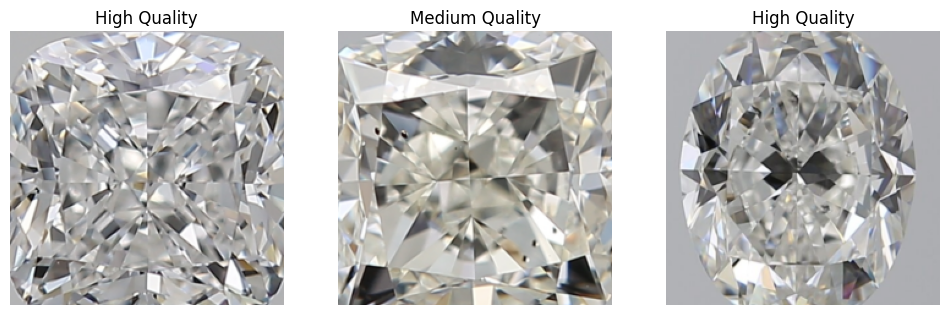

In [ ]:
def show_images(dataloader, class_names, number_of_images=3):
    # Get a batch of images
    images, labels = next(iter(dataloader))

    # Select a few images (number_of_images)
    images = images[:number_of_images]
    labels = labels[:number_of_images]

    # Invert normalization for display
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    fig, axes = plt.subplots(1, number_of_images, figsize=(12, 4))
    for img, label, ax in zip(images, labels, axes):
        img = inv_normalize(img)  # Invert the normalization
        img = img.numpy().transpose((1, 2, 0))  # Convert from tensor image
        ax.imshow(img)
        ax.set_title(class_names[label])  # Set the title to the corresponding class name
        ax.axis('off')
    plt.show()

# Assuming train_loader is your DataLoader and train_dataset.classes gives you class names
show_images(train_loader, train_dataset.classes)

# Model training

## Transfer Learning with existing model

In [ ]:
def get_precomputed_features_loader(model_name,dataloaders, save_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Load the appropriate pretrained model
    if model_name == 'vgg':
        model = models.vgg19(pretrained=True).features
    elif model_name == 'resnet':
        model = models.resnet50(pretrained=True)
        model = nn.Sequential(*list(model.children())[:-1])
    elif model_name == 'inception':
        model = models.inception_v3(pretrained=True, aux_logits=False)
        model = nn.Sequential(*list(model.children())[:-1])
    elif model_name == 'mobilenet':
        model = models.mobilenet_v2(pretrained=True)
        model = model.features
    elif model_name == 'efficientnet':
        model = models.efficientnet_b0(pretrained=True)
        model = nn.Sequential(*list(model.children())[:-1])
    else:
        raise ValueError("Unknown model name")

    model = model.to(device)
    model.eval()

  # Function to precompute features
    def precompute_features(dataloader, phase):
        conv_features = []
        labels_list = []
        for data in tqdm(dataloader, desc=f"Computing features for {phase} set"):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                x = model(inputs)
                x = x.view(x.size(0), -1)  # Flatten the features
                conv_features.extend(x.cpu().numpy())
                labels_list.extend(labels.cpu().numpy())

        # Convert lists to tensors
        conv_features = torch.tensor(np.array(conv_features), dtype=torch.float32)
        labels_list = torch.tensor(np.array(labels_list), dtype=torch.int64)

        # Save features and labels
        feature_path = os.path.join(save_dir, f"{model_name}_{phase}_features.pt")
        labels_path = os.path.join(save_dir, f"{model_name}_{phase}_labels.pt")
        torch.save(conv_features, feature_path)
        torch.save(labels_list, labels_path)

    # Compute and save features for each phase
    for phase, loader in dataloaders.items():
        precompute_features(loader, phase)

    print(f"Features computed and saved to {save_dir} for model {model_name}")

In [ ]:
def load_saved_features(model_name, save_dir):
    train_features = torch.load(os.path.join(save_dir, f'{model_name}_train_features.pt'))
    train_labels = torch.load(os.path.join(save_dir, f'{model_name}_train_labels.pt'))
    valid_features = torch.load(os.path.join(save_dir, f'{model_name}_valid_features.pt'))
    valid_labels = torch.load(os.path.join(save_dir, f'{model_name}_valid_labels.pt'))

    feature_loaders = {
        'train': DataLoader(TensorDataset(train_features, train_labels), batch_size=64, shuffle=True),
        'valid': DataLoader(TensorDataset(valid_features, valid_labels), batch_size=64, shuffle=False)
    }

    return feature_loaders

In [ ]:
def load_test_features(model_name, save_dir):
    features = torch.load(os.path.join(save_dir, f'{model_name}_test_features.pt'))
    labels = torch.load(os.path.join(save_dir, f'{model_name}_test_labels.pt'))

    return DataLoader(TensorDataset(features, labels), batch_size=64, shuffle=False)

In [ ]:
def train_classifier(model_name, feature_loaders, total_epochs = 10, num_classes = 3, save_dir = '',lr=0.0005, weight_decay=1e-4, dropout_rate = 0, optimizer = 'adam', momentum = 0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the model and modify its classifier's last layer
    if model_name == 'vgg':
        model = models.vgg19(pretrained=True)
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, num_classes)
        model = model.classifier
    elif model_name == 'resnet':
        model = nn.Sequential(nn.Linear(2048, num_classes))
    elif model_name == 'efficientnet':
        model = nn.Sequential(nn.Linear(1280, num_classes))
    elif model_name == 'vgg_hyper':
        model = create_vgg_classifier(num_classes, dropout_rate = dropout_rate)
    # Add similar modifications for other models as required

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer == 'adam':
      optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer == 'sgd':
      optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
      scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.03)
      decay = True

    train_loader = feature_loaders['train']
    valid_loader = feature_loaders['valid']

    # CSV file for storing metrics
    csv_file_path = os.path.join(save_dir, f'{model_name}_try_metrics.csv')

    # Prepare DataFrame to store losses and accuracies
    log_df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])

    for epoch in range(total_epochs):
        # Initialize metrics
        train_loss, train_correct, train_total = 0.0, 0, 0
        valid_loss, valid_correct, valid_total = 0.0, 0, 0

        # Training Phase
        model.train()
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{total_epochs} [Training]'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)
            train_total += labels.size(0)

        # Validation Phase
        model.eval()
        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc=f'Epoch {epoch+1}/{total_epochs} [Validation]'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                valid_correct += torch.sum(preds == labels.data)
                valid_total += labels.size(0)


        if decay:
            # Print current learning rate
            for param_group in optimizer.param_groups:
                print("Current learning rate is: {}".format(param_group['lr']))

            # Update the learning rate
            scheduler.step()

        # Calculate average loss and accuracy
        avg_train_loss = train_loss / len(feature_loaders['train'])
        avg_train_acc = train_correct.double() / train_total
        avg_valid_loss = valid_loss / len(feature_loaders['valid'])
        avg_valid_acc = valid_correct.double() / valid_total

         # Print average losses for the epoch
        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {avg_valid_acc:.2f}%")

        # Append metrics to DataFrame
        log_df = log_df.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_accuracy': avg_train_acc.item(),
            'valid_loss': avg_valid_loss,
            'valid_accuracy': avg_valid_acc.item()
        }, ignore_index=True)

        # Save DataFrame to CSV file
        log_df.to_csv(csv_file_path, index=False)

    print(f"Training completed. Metrics logged to {csv_file_path}.")
    return model,log_df

In [ ]:
def plot_loss_curves(model_name, csv_file_path):
    # Read the CSV file containing the loss data
    df = pd.read_csv(csv_file_path)

    # Extract the relevant columns for the specified model
    train_loss_column = f'train_loss'
    valid_loss_column = f'valid_loss'

    if train_loss_column in df.columns and valid_loss_column in df.columns:
        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(df[train_loss_column], label='Training Loss')
        plt.plot(df[valid_loss_column], label='Validation Loss')
        plt.title(f'{model_name} Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"Loss data for {model_name} not found in the CSV file.")

In [ ]:
# Get precomputed features
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# directory to save the features
save_model_dir = '/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/models'
# Train the classifier
save_log_dir = '/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata'


### VGG

In [ ]:
#get_precomputed_features_loader('vgg', data_loaders, save_model_dir)
vgg_feature_loaders = load_saved_features('vgg',save_model_dir)

In [ ]:
for inputs, labels in vgg_feature_loaders['train']:
    print(f"Input batch shape: {inputs.shape}")
    print(f"Label batch shape: {labels.shape}")
    break  # After printing the shapes, break out of the loop

Input batch shape: torch.Size([64, 25088])
Label batch shape: torch.Size([64])


In [ ]:
vgg_model,vgg_log = train_classifier('vgg', vgg_feature_loaders, total_epochs=20, num_classes=3, save_dir =save_log_dir,lr=0.005, weight_decay = 1e-3,dropout_rate = 0.5,optimizer = 'sgd', momentum = 0.8)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 106.56it/s]


Current learning rate is: 0.005
Epoch 1 - Train Loss: 0.7182, Train Acc: 0.73%, Valid Loss: 0.6471, Valid Acc: 0.75%


Epoch 2/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 116.00it/s]


Current learning rate is: 0.005
Epoch 2 - Train Loss: 0.6455, Train Acc: 0.75%, Valid Loss: 0.6662, Valid Acc: 0.75%


Epoch 3/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 104.81it/s]


Current learning rate is: 0.005
Epoch 3 - Train Loss: 0.6175, Train Acc: 0.75%, Valid Loss: 0.6119, Valid Acc: 0.76%


Epoch 4/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 114.42it/s]


Current learning rate is: 0.005
Epoch 4 - Train Loss: 0.5955, Train Acc: 0.75%, Valid Loss: 0.5989, Valid Acc: 0.76%


Epoch 5/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 77.90it/s]


Current learning rate is: 0.005
Epoch 5 - Train Loss: 0.5840, Train Acc: 0.76%, Valid Loss: 0.5869, Valid Acc: 0.77%


Epoch 6/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 107.54it/s]


Current learning rate is: 0.005
Epoch 6 - Train Loss: 0.5617, Train Acc: 0.77%, Valid Loss: 0.5950, Valid Acc: 0.77%


Epoch 7/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 114.43it/s]


Current learning rate is: 0.005
Epoch 7 - Train Loss: 0.5468, Train Acc: 0.77%, Valid Loss: 0.5831, Valid Acc: 0.77%


Epoch 8/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 109.25it/s]


Current learning rate is: 0.005
Epoch 8 - Train Loss: 0.5347, Train Acc: 0.77%, Valid Loss: 0.5860, Valid Acc: 0.77%


Epoch 9/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 114.81it/s]


Current learning rate is: 0.005
Epoch 9 - Train Loss: 0.5158, Train Acc: 0.78%, Valid Loss: 0.5975, Valid Acc: 0.77%


Epoch 10/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 102.72it/s]


Current learning rate is: 0.005
Epoch 10 - Train Loss: 0.5081, Train Acc: 0.78%, Valid Loss: 0.5896, Valid Acc: 0.77%


Epoch 11/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 114.33it/s]


Current learning rate is: 0.00015
Epoch 11 - Train Loss: 0.4576, Train Acc: 0.81%, Valid Loss: 0.5847, Valid Acc: 0.77%


Epoch 12/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 110.10it/s]


Current learning rate is: 0.00015
Epoch 12 - Train Loss: 0.4503, Train Acc: 0.81%, Valid Loss: 0.5840, Valid Acc: 0.77%


Epoch 13/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 111.20it/s]


Current learning rate is: 0.00015
Epoch 13 - Train Loss: 0.4385, Train Acc: 0.82%, Valid Loss: 0.5845, Valid Acc: 0.77%


Epoch 14/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 113.90it/s]


Current learning rate is: 0.00015
Epoch 14 - Train Loss: 0.4364, Train Acc: 0.81%, Valid Loss: 0.5859, Valid Acc: 0.76%


Epoch 15/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 111.88it/s]


Current learning rate is: 0.00015
Epoch 15 - Train Loss: 0.4299, Train Acc: 0.82%, Valid Loss: 0.5877, Valid Acc: 0.76%


Epoch 16/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 113.22it/s]


Current learning rate is: 0.00015
Epoch 16 - Train Loss: 0.4246, Train Acc: 0.82%, Valid Loss: 0.5877, Valid Acc: 0.77%


Epoch 17/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 105.88it/s]


Current learning rate is: 0.00015
Epoch 17 - Train Loss: 0.4202, Train Acc: 0.82%, Valid Loss: 0.5884, Valid Acc: 0.77%


Epoch 18/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 111.91it/s]


Current learning rate is: 0.00015
Epoch 18 - Train Loss: 0.4156, Train Acc: 0.83%, Valid Loss: 0.5897, Valid Acc: 0.76%


Epoch 19/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 107.54it/s]


Current learning rate is: 0.00015
Epoch 19 - Train Loss: 0.4120, Train Acc: 0.83%, Valid Loss: 0.5902, Valid Acc: 0.77%


Epoch 20/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 113.23it/s]

Current learning rate is: 0.00015
Epoch 20 - Train Loss: 0.4098, Train Acc: 0.83%, Valid Loss: 0.5938, Valid Acc: 0.75%
Training completed. Metrics logged to /content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/vgg_try_metrics.csv.


In [ ]:
# Step 1: Get a single sample
for inputs, labels in vgg_feature_loaders['train']:
    single_input = inputs[0].unsqueeze(0)
    single_label = labels[0].unsqueeze(0)
    break

# Step 2: Make a prediction
vgg_model.eval()  # Set the model to evaluation mode
single_input = single_input.to(device)
with torch.no_grad():
    single_output = vgg_model(single_input)

# Step 3: Print the output shape
print(f"The shape of the output for one sample is: {single_output.shape}")

The shape of the output for one sample is: torch.Size([1, 3])


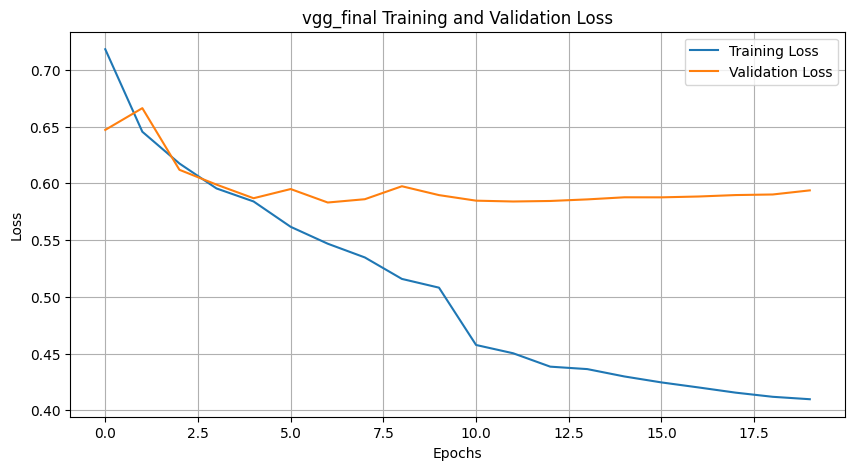

In [ ]:
# Example usage
plot_loss_curves('vgg_final', '/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/vgg_try_metrics.csv')

In [ ]:
# Assuming 'model' is your model instance
model_path = '/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/models/vgg_l2_model.pth'  # Specify your path here
torch.save(vgg_model, model_path)

### ResNet

In [ ]:
#get_precomputed_features_loader('resnet', data_loaders, save_model_dir, device)
resnet_feature_loaders = load_saved_features('resnet',save_model_dir)

In [ ]:
for inputs, labels in resnet_feature_loaders['train']:
    print(f"Input batch shape: {inputs.shape}")
    print(f"Label batch shape: {labels.shape}")
    break  # After printing the shapes, break out of the loop

Input batch shape: torch.Size([64, 2048])
Label batch shape: torch.Size([64])


In [ ]:
resnet_model,resnet_log = train_classifier('resnet', resnet_feature_loaders, total_epochs=200, num_classes=3, save_dir =save_log_dir)

Epoch 1/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 290.07it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 1 - Train Loss: 0.7354, Train Acc: 0.72%, Valid Loss: 0.7017, Valid Acc: 0.73%


Epoch 2/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 645.84it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 2 - Train Loss: 0.6900, Train Acc: 0.73%, Valid Loss: 0.6771, Valid Acc: 0.74%


Epoch 3/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 858.19it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 3 - Train Loss: 0.6770, Train Acc: 0.74%, Valid Loss: 0.6637, Valid Acc: 0.75%


Epoch 4/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 829.82it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 4 - Train Loss: 0.6651, Train Acc: 0.74%, Valid Loss: 0.6732, Valid Acc: 0.75%


Epoch 5/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 822.72it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 5 - Train Loss: 0.6591, Train Acc: 0.74%, Valid Loss: 0.6565, Valid Acc: 0.75%


Epoch 6/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 933.17it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 6 - Train Loss: 0.6536, Train Acc: 0.74%, Valid Loss: 0.6691, Valid Acc: 0.75%


Epoch 7/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 871.84it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 7 - Train Loss: 0.6482, Train Acc: 0.74%, Valid Loss: 0.6601, Valid Acc: 0.75%


Epoch 8/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 816.66it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 8 - Train Loss: 0.6485, Train Acc: 0.74%, Valid Loss: 0.6594, Valid Acc: 0.75%


Epoch 9/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 831.82it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 9 - Train Loss: 0.6461, Train Acc: 0.74%, Valid Loss: 0.6559, Valid Acc: 0.75%


Epoch 10/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 857.89it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 10 - Train Loss: 0.6410, Train Acc: 0.74%, Valid Loss: 0.6548, Valid Acc: 0.75%


Epoch 11/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 949.97it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 11 - Train Loss: 0.6360, Train Acc: 0.75%, Valid Loss: 0.6598, Valid Acc: 0.75%


Epoch 12/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 836.89it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 12 - Train Loss: 0.6341, Train Acc: 0.75%, Valid Loss: 0.6572, Valid Acc: 0.75%


Epoch 13/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 818.74it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 13 - Train Loss: 0.6344, Train Acc: 0.75%, Valid Loss: 0.6499, Valid Acc: 0.76%


Epoch 14/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 814.89it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 14 - Train Loss: 0.6298, Train Acc: 0.75%, Valid Loss: 0.6424, Valid Acc: 0.76%


Epoch 15/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 626.58it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 15 - Train Loss: 0.6260, Train Acc: 0.75%, Valid Loss: 0.6552, Valid Acc: 0.75%


Epoch 16/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 635.92it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 16 - Train Loss: 0.6267, Train Acc: 0.75%, Valid Loss: 0.6384, Valid Acc: 0.76%


Epoch 17/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 691.61it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 17 - Train Loss: 0.6223, Train Acc: 0.75%, Valid Loss: 0.6535, Valid Acc: 0.75%


Epoch 18/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 561.47it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 18 - Train Loss: 0.6237, Train Acc: 0.75%, Valid Loss: 0.6479, Valid Acc: 0.75%


Epoch 19/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 570.37it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 19 - Train Loss: 0.6202, Train Acc: 0.75%, Valid Loss: 0.6464, Valid Acc: 0.75%


Epoch 20/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 552.44it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 20 - Train Loss: 0.6221, Train Acc: 0.75%, Valid Loss: 0.6529, Valid Acc: 0.75%


Epoch 21/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 553.28it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 21 - Train Loss: 0.6186, Train Acc: 0.75%, Valid Loss: 0.6382, Valid Acc: 0.76%


Epoch 22/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 540.25it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 22 - Train Loss: 0.6189, Train Acc: 0.75%, Valid Loss: 0.6430, Valid Acc: 0.75%


Epoch 23/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 797.83it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 23 - Train Loss: 0.6159, Train Acc: 0.76%, Valid Loss: 0.6427, Valid Acc: 0.76%


Epoch 24/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 783.37it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 24 - Train Loss: 0.6176, Train Acc: 0.75%, Valid Loss: 0.6395, Valid Acc: 0.76%


Epoch 25/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 754.53it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 25 - Train Loss: 0.6111, Train Acc: 0.75%, Valid Loss: 0.6357, Valid Acc: 0.76%


Epoch 26/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 889.05it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 26 - Train Loss: 0.6112, Train Acc: 0.76%, Valid Loss: 0.6488, Valid Acc: 0.76%


Epoch 27/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 863.91it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 27 - Train Loss: 0.6123, Train Acc: 0.76%, Valid Loss: 0.6355, Valid Acc: 0.76%


Epoch 28/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 861.77it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 28 - Train Loss: 0.6112, Train Acc: 0.76%, Valid Loss: 0.6434, Valid Acc: 0.76%


Epoch 29/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 878.12it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 29 - Train Loss: 0.6059, Train Acc: 0.76%, Valid Loss: 0.6528, Valid Acc: 0.74%


Epoch 30/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 827.93it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 30 - Train Loss: 0.6092, Train Acc: 0.76%, Valid Loss: 0.6403, Valid Acc: 0.76%


Epoch 31/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 938.64it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 31 - Train Loss: 0.6089, Train Acc: 0.76%, Valid Loss: 0.6329, Valid Acc: 0.76%


Epoch 32/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 845.59it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 32 - Train Loss: 0.6047, Train Acc: 0.76%, Valid Loss: 0.6387, Valid Acc: 0.75%


Epoch 33/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 838.67it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 33 - Train Loss: 0.6055, Train Acc: 0.76%, Valid Loss: 0.6549, Valid Acc: 0.76%


Epoch 34/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 850.78it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 34 - Train Loss: 0.6020, Train Acc: 0.76%, Valid Loss: 0.6495, Valid Acc: 0.76%


Epoch 35/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 901.58it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 35 - Train Loss: 0.6032, Train Acc: 0.76%, Valid Loss: 0.6357, Valid Acc: 0.76%


Epoch 36/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 824.06it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 36 - Train Loss: 0.6029, Train Acc: 0.76%, Valid Loss: 0.6445, Valid Acc: 0.76%


Epoch 37/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 935.60it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 37 - Train Loss: 0.5997, Train Acc: 0.76%, Valid Loss: 0.6306, Valid Acc: 0.76%


Epoch 38/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 843.46it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 38 - Train Loss: 0.6010, Train Acc: 0.76%, Valid Loss: 0.6343, Valid Acc: 0.76%


Epoch 39/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 734.44it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 39 - Train Loss: 0.5979, Train Acc: 0.76%, Valid Loss: 0.6502, Valid Acc: 0.75%


Epoch 40/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 596.13it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 40 - Train Loss: 0.5964, Train Acc: 0.76%, Valid Loss: 0.6540, Valid Acc: 0.75%


Epoch 41/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 679.54it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 41 - Train Loss: 0.5959, Train Acc: 0.76%, Valid Loss: 0.6349, Valid Acc: 0.75%


Epoch 42/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 597.28it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 42 - Train Loss: 0.5957, Train Acc: 0.76%, Valid Loss: 0.6513, Valid Acc: 0.76%


Epoch 43/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 572.41it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 43 - Train Loss: 0.5993, Train Acc: 0.76%, Valid Loss: 0.6329, Valid Acc: 0.76%


Epoch 44/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 600.69it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 44 - Train Loss: 0.5977, Train Acc: 0.76%, Valid Loss: 0.6380, Valid Acc: 0.76%


Epoch 45/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 646.16it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 45 - Train Loss: 0.5927, Train Acc: 0.76%, Valid Loss: 0.7058, Valid Acc: 0.76%


Epoch 46/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 593.56it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 46 - Train Loss: 0.5973, Train Acc: 0.76%, Valid Loss: 0.6428, Valid Acc: 0.76%


Epoch 47/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 549.35it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 47 - Train Loss: 0.5904, Train Acc: 0.76%, Valid Loss: 0.6437, Valid Acc: 0.74%


Epoch 48/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 900.62it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 48 - Train Loss: 0.5909, Train Acc: 0.76%, Valid Loss: 0.6407, Valid Acc: 0.75%


Epoch 49/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 880.25it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 49 - Train Loss: 0.5942, Train Acc: 0.76%, Valid Loss: 0.6320, Valid Acc: 0.76%


Epoch 50/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 922.71it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 50 - Train Loss: 0.5900, Train Acc: 0.76%, Valid Loss: 0.6440, Valid Acc: 0.76%


Epoch 51/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 868.45it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 51 - Train Loss: 0.5918, Train Acc: 0.76%, Valid Loss: 0.6290, Valid Acc: 0.76%


Epoch 52/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 796.21it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 52 - Train Loss: 0.5906, Train Acc: 0.76%, Valid Loss: 0.6295, Valid Acc: 0.76%


Epoch 53/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 867.40it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 53 - Train Loss: 0.5888, Train Acc: 0.76%, Valid Loss: 0.6442, Valid Acc: 0.74%


Epoch 54/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 922.03it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 54 - Train Loss: 0.5894, Train Acc: 0.76%, Valid Loss: 0.6681, Valid Acc: 0.74%


Epoch 55/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 875.01it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 55 - Train Loss: 0.5890, Train Acc: 0.76%, Valid Loss: 0.6321, Valid Acc: 0.76%


Epoch 56/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 820.00it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 56 - Train Loss: 0.5856, Train Acc: 0.77%, Valid Loss: 0.6315, Valid Acc: 0.76%


Epoch 57/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 826.39it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 57 - Train Loss: 0.5848, Train Acc: 0.76%, Valid Loss: 0.6435, Valid Acc: 0.75%


Epoch 58/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 849.92it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 58 - Train Loss: 0.5891, Train Acc: 0.76%, Valid Loss: 0.6342, Valid Acc: 0.76%


Epoch 59/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 855.99it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 59 - Train Loss: 0.5838, Train Acc: 0.76%, Valid Loss: 0.6337, Valid Acc: 0.76%


Epoch 60/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 884.62it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 60 - Train Loss: 0.5859, Train Acc: 0.77%, Valid Loss: 0.6360, Valid Acc: 0.76%


Epoch 61/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 917.66it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 61 - Train Loss: 0.5851, Train Acc: 0.76%, Valid Loss: 0.6299, Valid Acc: 0.76%


Epoch 62/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 832.74it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 62 - Train Loss: 0.5807, Train Acc: 0.77%, Valid Loss: 0.6372, Valid Acc: 0.76%


Epoch 63/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 937.29it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 63 - Train Loss: 0.5833, Train Acc: 0.77%, Valid Loss: 0.6601, Valid Acc: 0.73%


Epoch 64/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 575.89it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 64 - Train Loss: 0.5829, Train Acc: 0.77%, Valid Loss: 0.6347, Valid Acc: 0.75%


Epoch 65/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 593.66it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 65 - Train Loss: 0.5818, Train Acc: 0.76%, Valid Loss: 0.6300, Valid Acc: 0.76%


Epoch 66/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 672.26it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 66 - Train Loss: 0.5796, Train Acc: 0.77%, Valid Loss: 0.6371, Valid Acc: 0.75%


Epoch 67/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 581.39it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 67 - Train Loss: 0.5853, Train Acc: 0.77%, Valid Loss: 0.6330, Valid Acc: 0.76%


Epoch 68/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 634.65it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 68 - Train Loss: 0.5812, Train Acc: 0.77%, Valid Loss: 0.6389, Valid Acc: 0.76%


Epoch 69/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 551.48it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 69 - Train Loss: 0.5805, Train Acc: 0.77%, Valid Loss: 0.6311, Valid Acc: 0.76%


Epoch 70/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 637.75it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 70 - Train Loss: 0.5815, Train Acc: 0.77%, Valid Loss: 0.6595, Valid Acc: 0.73%


Epoch 71/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 685.40it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 71 - Train Loss: 0.5835, Train Acc: 0.77%, Valid Loss: 0.6393, Valid Acc: 0.75%


Epoch 72/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 836.87it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 72 - Train Loss: 0.5815, Train Acc: 0.77%, Valid Loss: 0.6409, Valid Acc: 0.75%


Epoch 73/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 862.88it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 73 - Train Loss: 0.5738, Train Acc: 0.77%, Valid Loss: 0.6361, Valid Acc: 0.75%


Epoch 74/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 870.90it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 74 - Train Loss: 0.5752, Train Acc: 0.77%, Valid Loss: 0.6518, Valid Acc: 0.76%


Epoch 75/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 898.69it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 75 - Train Loss: 0.5787, Train Acc: 0.76%, Valid Loss: 0.6368, Valid Acc: 0.75%


Epoch 76/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 916.39it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 76 - Train Loss: 0.5774, Train Acc: 0.77%, Valid Loss: 0.6369, Valid Acc: 0.75%


Epoch 77/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 880.63it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 77 - Train Loss: 0.5775, Train Acc: 0.77%, Valid Loss: 0.6436, Valid Acc: 0.75%


Epoch 78/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 880.22it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 78 - Train Loss: 0.5808, Train Acc: 0.77%, Valid Loss: 0.6455, Valid Acc: 0.76%


Epoch 79/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 923.07it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 79 - Train Loss: 0.5761, Train Acc: 0.77%, Valid Loss: 0.6488, Valid Acc: 0.76%


Epoch 80/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 873.79it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 80 - Train Loss: 0.5767, Train Acc: 0.77%, Valid Loss: 0.6319, Valid Acc: 0.76%


Epoch 81/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 905.93it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 81 - Train Loss: 0.5742, Train Acc: 0.77%, Valid Loss: 0.6399, Valid Acc: 0.76%


Epoch 82/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 868.64it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 82 - Train Loss: 0.5757, Train Acc: 0.77%, Valid Loss: 0.6341, Valid Acc: 0.76%


Epoch 83/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 814.91it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 83 - Train Loss: 0.5732, Train Acc: 0.77%, Valid Loss: 0.6445, Valid Acc: 0.76%


Epoch 84/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 770.14it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 84 - Train Loss: 0.5736, Train Acc: 0.77%, Valid Loss: 0.6344, Valid Acc: 0.76%


Epoch 85/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 907.31it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 85 - Train Loss: 0.5783, Train Acc: 0.76%, Valid Loss: 0.6286, Valid Acc: 0.76%


Epoch 86/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 841.28it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 86 - Train Loss: 0.5710, Train Acc: 0.77%, Valid Loss: 0.6502, Valid Acc: 0.75%


Epoch 87/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 829.12it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 87 - Train Loss: 0.5711, Train Acc: 0.77%, Valid Loss: 0.6400, Valid Acc: 0.76%


Epoch 88/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 868.84it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 88 - Train Loss: 0.5716, Train Acc: 0.77%, Valid Loss: 0.6339, Valid Acc: 0.75%


Epoch 89/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 665.52it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 89 - Train Loss: 0.5708, Train Acc: 0.77%, Valid Loss: 0.6307, Valid Acc: 0.75%


Epoch 90/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 627.53it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 90 - Train Loss: 0.5698, Train Acc: 0.77%, Valid Loss: 0.6349, Valid Acc: 0.75%


Epoch 91/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 667.33it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 91 - Train Loss: 0.5720, Train Acc: 0.77%, Valid Loss: 0.6337, Valid Acc: 0.76%


Epoch 92/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 700.51it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 92 - Train Loss: 0.5726, Train Acc: 0.77%, Valid Loss: 0.6295, Valid Acc: 0.75%


Epoch 93/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 628.08it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 93 - Train Loss: 0.5678, Train Acc: 0.77%, Valid Loss: 0.6289, Valid Acc: 0.75%


Epoch 94/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 586.43it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 94 - Train Loss: 0.5711, Train Acc: 0.77%, Valid Loss: 0.6319, Valid Acc: 0.76%


Epoch 95/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 625.35it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 95 - Train Loss: 0.5667, Train Acc: 0.77%, Valid Loss: 0.6317, Valid Acc: 0.76%


Epoch 96/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 590.77it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 96 - Train Loss: 0.5679, Train Acc: 0.77%, Valid Loss: 0.6258, Valid Acc: 0.76%


Epoch 97/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 802.42it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 97 - Train Loss: 0.5697, Train Acc: 0.77%, Valid Loss: 0.6389, Valid Acc: 0.76%


Epoch 98/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 896.06it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 98 - Train Loss: 0.5712, Train Acc: 0.77%, Valid Loss: 0.6804, Valid Acc: 0.76%


Epoch 99/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 899.96it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 99 - Train Loss: 0.5660, Train Acc: 0.77%, Valid Loss: 0.6357, Valid Acc: 0.75%


Epoch 100/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 874.85it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 100 - Train Loss: 0.5664, Train Acc: 0.77%, Valid Loss: 0.6320, Valid Acc: 0.75%


Epoch 101/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 786.91it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 101 - Train Loss: 0.5645, Train Acc: 0.77%, Valid Loss: 0.6325, Valid Acc: 0.76%


Epoch 102/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 903.69it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 102 - Train Loss: 0.5690, Train Acc: 0.77%, Valid Loss: 0.6353, Valid Acc: 0.76%


Epoch 103/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 888.86it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 103 - Train Loss: 0.5725, Train Acc: 0.77%, Valid Loss: 0.6393, Valid Acc: 0.76%


Epoch 104/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 808.90it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 104 - Train Loss: 0.5639, Train Acc: 0.77%, Valid Loss: 0.6319, Valid Acc: 0.75%


Epoch 105/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 863.19it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 105 - Train Loss: 0.5658, Train Acc: 0.77%, Valid Loss: 0.6337, Valid Acc: 0.76%


Epoch 106/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 825.95it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 106 - Train Loss: 0.5625, Train Acc: 0.77%, Valid Loss: 0.6356, Valid Acc: 0.76%


Epoch 107/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 910.63it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 107 - Train Loss: 0.5608, Train Acc: 0.77%, Valid Loss: 0.6314, Valid Acc: 0.76%


Epoch 108/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 894.79it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 108 - Train Loss: 0.5640, Train Acc: 0.77%, Valid Loss: 0.6346, Valid Acc: 0.76%


Epoch 109/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 943.43it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 109 - Train Loss: 0.5625, Train Acc: 0.77%, Valid Loss: 0.6302, Valid Acc: 0.75%


Epoch 110/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 828.61it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 110 - Train Loss: 0.5607, Train Acc: 0.77%, Valid Loss: 0.6490, Valid Acc: 0.76%


Epoch 111/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 812.26it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 111 - Train Loss: 0.5644, Train Acc: 0.77%, Valid Loss: 0.6337, Valid Acc: 0.76%


Epoch 112/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 901.94it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 112 - Train Loss: 0.5587, Train Acc: 0.77%, Valid Loss: 0.6306, Valid Acc: 0.76%


Epoch 113/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 520.97it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 113 - Train Loss: 0.5617, Train Acc: 0.77%, Valid Loss: 0.6297, Valid Acc: 0.75%


Epoch 114/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 678.64it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 114 - Train Loss: 0.5613, Train Acc: 0.77%, Valid Loss: 0.6295, Valid Acc: 0.75%


Epoch 115/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 581.99it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 115 - Train Loss: 0.5591, Train Acc: 0.77%, Valid Loss: 0.6343, Valid Acc: 0.76%


Epoch 116/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 544.11it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 116 - Train Loss: 0.5604, Train Acc: 0.77%, Valid Loss: 0.6720, Valid Acc: 0.76%


Epoch 117/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 599.95it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 117 - Train Loss: 0.5652, Train Acc: 0.77%, Valid Loss: 0.6284, Valid Acc: 0.76%


Epoch 118/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 558.31it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 118 - Train Loss: 0.5601, Train Acc: 0.77%, Valid Loss: 0.6399, Valid Acc: 0.75%


Epoch 119/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 668.87it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 119 - Train Loss: 0.5591, Train Acc: 0.78%, Valid Loss: 0.6318, Valid Acc: 0.76%


Epoch 120/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 589.83it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 120 - Train Loss: 0.5593, Train Acc: 0.77%, Valid Loss: 0.6413, Valid Acc: 0.74%


Epoch 121/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 920.12it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 121 - Train Loss: 0.5628, Train Acc: 0.77%, Valid Loss: 0.6374, Valid Acc: 0.76%


Epoch 122/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 881.68it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 122 - Train Loss: 0.5631, Train Acc: 0.77%, Valid Loss: 0.6608, Valid Acc: 0.75%


Epoch 123/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 801.75it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 123 - Train Loss: 0.5604, Train Acc: 0.77%, Valid Loss: 0.6449, Valid Acc: 0.75%


Epoch 124/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 850.76it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 124 - Train Loss: 0.5597, Train Acc: 0.77%, Valid Loss: 0.6319, Valid Acc: 0.76%


Epoch 125/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 861.58it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 125 - Train Loss: 0.5573, Train Acc: 0.77%, Valid Loss: 0.6292, Valid Acc: 0.75%


Epoch 126/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 772.84it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 126 - Train Loss: 0.5567, Train Acc: 0.77%, Valid Loss: 0.6400, Valid Acc: 0.76%


Epoch 127/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 802.44it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 127 - Train Loss: 0.5576, Train Acc: 0.77%, Valid Loss: 0.6296, Valid Acc: 0.75%


Epoch 128/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 689.02it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 128 - Train Loss: 0.5573, Train Acc: 0.77%, Valid Loss: 0.6435, Valid Acc: 0.76%


Epoch 129/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 763.90it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 129 - Train Loss: 0.5558, Train Acc: 0.78%, Valid Loss: 0.6379, Valid Acc: 0.75%


Epoch 130/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 718.62it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 130 - Train Loss: 0.5578, Train Acc: 0.77%, Valid Loss: 0.6478, Valid Acc: 0.76%


Epoch 131/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 811.95it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 131 - Train Loss: 0.5548, Train Acc: 0.78%, Valid Loss: 0.6289, Valid Acc: 0.75%


Epoch 132/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 788.37it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 132 - Train Loss: 0.5573, Train Acc: 0.78%, Valid Loss: 0.6393, Valid Acc: 0.76%


Epoch 133/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 845.68it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 133 - Train Loss: 0.5599, Train Acc: 0.77%, Valid Loss: 0.6438, Valid Acc: 0.75%


Epoch 134/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 784.44it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 134 - Train Loss: 0.5579, Train Acc: 0.77%, Valid Loss: 0.6416, Valid Acc: 0.76%


Epoch 135/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 876.27it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 135 - Train Loss: 0.5536, Train Acc: 0.78%, Valid Loss: 0.6506, Valid Acc: 0.76%


Epoch 136/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 739.50it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 136 - Train Loss: 0.5527, Train Acc: 0.78%, Valid Loss: 0.6308, Valid Acc: 0.76%


Epoch 137/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 582.75it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 137 - Train Loss: 0.5517, Train Acc: 0.78%, Valid Loss: 0.6346, Valid Acc: 0.75%


Epoch 138/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 641.57it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 138 - Train Loss: 0.5518, Train Acc: 0.78%, Valid Loss: 0.6339, Valid Acc: 0.75%


Epoch 139/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 678.72it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 139 - Train Loss: 0.5512, Train Acc: 0.78%, Valid Loss: 0.6501, Valid Acc: 0.76%


Epoch 140/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 609.39it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 140 - Train Loss: 0.5518, Train Acc: 0.78%, Valid Loss: 0.6418, Valid Acc: 0.75%


Epoch 141/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 627.47it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 141 - Train Loss: 0.5547, Train Acc: 0.77%, Valid Loss: 0.6443, Valid Acc: 0.74%


Epoch 142/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 580.48it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 142 - Train Loss: 0.5522, Train Acc: 0.78%, Valid Loss: 0.6287, Valid Acc: 0.75%


Epoch 143/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 678.24it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 143 - Train Loss: 0.5521, Train Acc: 0.78%, Valid Loss: 0.6347, Valid Acc: 0.76%


Epoch 144/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 510.90it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 144 - Train Loss: 0.5524, Train Acc: 0.78%, Valid Loss: 0.6291, Valid Acc: 0.76%


Epoch 145/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 926.87it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 145 - Train Loss: 0.5525, Train Acc: 0.78%, Valid Loss: 0.6352, Valid Acc: 0.75%


Epoch 146/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 860.57it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 146 - Train Loss: 0.5492, Train Acc: 0.78%, Valid Loss: 0.6297, Valid Acc: 0.75%


Epoch 147/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 867.61it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 147 - Train Loss: 0.5531, Train Acc: 0.78%, Valid Loss: 0.6518, Valid Acc: 0.76%


Epoch 148/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 822.55it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 148 - Train Loss: 0.5486, Train Acc: 0.78%, Valid Loss: 0.6337, Valid Acc: 0.76%


Epoch 149/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 803.48it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 149 - Train Loss: 0.5522, Train Acc: 0.78%, Valid Loss: 0.6373, Valid Acc: 0.75%


Epoch 150/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 828.03it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 150 - Train Loss: 0.5502, Train Acc: 0.78%, Valid Loss: 0.6294, Valid Acc: 0.75%


Epoch 151/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 881.35it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 151 - Train Loss: 0.5526, Train Acc: 0.78%, Valid Loss: 0.6296, Valid Acc: 0.76%


Epoch 152/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 864.07it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 152 - Train Loss: 0.5506, Train Acc: 0.78%, Valid Loss: 0.6391, Valid Acc: 0.76%


Epoch 153/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 910.46it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 153 - Train Loss: 0.5499, Train Acc: 0.78%, Valid Loss: 0.6409, Valid Acc: 0.75%


Epoch 154/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 738.79it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 154 - Train Loss: 0.5489, Train Acc: 0.77%, Valid Loss: 0.6405, Valid Acc: 0.76%


Epoch 155/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 829.85it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 155 - Train Loss: 0.5508, Train Acc: 0.78%, Valid Loss: 0.6437, Valid Acc: 0.75%


Epoch 156/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 824.94it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 156 - Train Loss: 0.5471, Train Acc: 0.78%, Valid Loss: 0.6346, Valid Acc: 0.76%


Epoch 157/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 727.19it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 157 - Train Loss: 0.5457, Train Acc: 0.78%, Valid Loss: 0.6394, Valid Acc: 0.75%


Epoch 158/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 804.91it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 158 - Train Loss: 0.5478, Train Acc: 0.78%, Valid Loss: 0.6316, Valid Acc: 0.75%


Epoch 159/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 934.48it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 159 - Train Loss: 0.5515, Train Acc: 0.77%, Valid Loss: 0.6758, Valid Acc: 0.71%


Epoch 160/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 807.43it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 160 - Train Loss: 0.5462, Train Acc: 0.78%, Valid Loss: 0.6310, Valid Acc: 0.76%


Epoch 161/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 619.30it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 161 - Train Loss: 0.5494, Train Acc: 0.78%, Valid Loss: 0.6375, Valid Acc: 0.75%


Epoch 162/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 693.46it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 162 - Train Loss: 0.5505, Train Acc: 0.78%, Valid Loss: 0.6349, Valid Acc: 0.76%


Epoch 163/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 605.75it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 163 - Train Loss: 0.5477, Train Acc: 0.78%, Valid Loss: 0.6453, Valid Acc: 0.76%


Epoch 164/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 581.42it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 164 - Train Loss: 0.5450, Train Acc: 0.78%, Valid Loss: 0.6286, Valid Acc: 0.75%


Epoch 165/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 518.43it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 165 - Train Loss: 0.5462, Train Acc: 0.78%, Valid Loss: 0.6464, Valid Acc: 0.75%


Epoch 166/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 703.47it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 166 - Train Loss: 0.5458, Train Acc: 0.78%, Valid Loss: 0.6329, Valid Acc: 0.76%


Epoch 167/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 603.62it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 167 - Train Loss: 0.5456, Train Acc: 0.78%, Valid Loss: 0.6352, Valid Acc: 0.76%


Epoch 168/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 590.16it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 168 - Train Loss: 0.5445, Train Acc: 0.78%, Valid Loss: 0.6354, Valid Acc: 0.75%


Epoch 169/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 608.30it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 169 - Train Loss: 0.5503, Train Acc: 0.78%, Valid Loss: 0.6448, Valid Acc: 0.75%


Epoch 170/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 750.49it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 170 - Train Loss: 0.5488, Train Acc: 0.78%, Valid Loss: 0.6352, Valid Acc: 0.75%


Epoch 171/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 880.74it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 171 - Train Loss: 0.5456, Train Acc: 0.78%, Valid Loss: 0.6803, Valid Acc: 0.76%


Epoch 172/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 889.97it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 172 - Train Loss: 0.5422, Train Acc: 0.78%, Valid Loss: 0.6442, Valid Acc: 0.76%


Epoch 173/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 848.13it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 173 - Train Loss: 0.5433, Train Acc: 0.78%, Valid Loss: 0.6439, Valid Acc: 0.75%


Epoch 174/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 849.70it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 174 - Train Loss: 0.5464, Train Acc: 0.78%, Valid Loss: 0.6329, Valid Acc: 0.76%


Epoch 175/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 828.80it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 175 - Train Loss: 0.5465, Train Acc: 0.78%, Valid Loss: 0.6416, Valid Acc: 0.75%


Epoch 176/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 938.42it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 176 - Train Loss: 0.5433, Train Acc: 0.78%, Valid Loss: 0.6394, Valid Acc: 0.76%


Epoch 177/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 888.25it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 177 - Train Loss: 0.5453, Train Acc: 0.78%, Valid Loss: 0.6539, Valid Acc: 0.76%


Epoch 178/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 905.93it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 178 - Train Loss: 0.5434, Train Acc: 0.78%, Valid Loss: 0.6512, Valid Acc: 0.76%


Epoch 179/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 828.24it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 179 - Train Loss: 0.5439, Train Acc: 0.78%, Valid Loss: 0.6336, Valid Acc: 0.75%


Epoch 180/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 786.37it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 180 - Train Loss: 0.5424, Train Acc: 0.78%, Valid Loss: 0.6324, Valid Acc: 0.76%


Epoch 181/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 911.01it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 181 - Train Loss: 0.5446, Train Acc: 0.78%, Valid Loss: 0.6339, Valid Acc: 0.75%


Epoch 182/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 837.07it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 182 - Train Loss: 0.5441, Train Acc: 0.78%, Valid Loss: 0.6361, Valid Acc: 0.76%


Epoch 183/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 852.62it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 183 - Train Loss: 0.5425, Train Acc: 0.78%, Valid Loss: 0.6374, Valid Acc: 0.76%


Epoch 184/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 881.89it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 184 - Train Loss: 0.5442, Train Acc: 0.78%, Valid Loss: 0.6337, Valid Acc: 0.75%


Epoch 185/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 795.21it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 185 - Train Loss: 0.5466, Train Acc: 0.78%, Valid Loss: 0.6410, Valid Acc: 0.75%


Epoch 186/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 577.13it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 186 - Train Loss: 0.5397, Train Acc: 0.78%, Valid Loss: 0.6337, Valid Acc: 0.75%


Epoch 187/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 609.22it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 187 - Train Loss: 0.5431, Train Acc: 0.78%, Valid Loss: 0.6399, Valid Acc: 0.76%


Epoch 188/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 597.17it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 188 - Train Loss: 0.5386, Train Acc: 0.78%, Valid Loss: 0.6370, Valid Acc: 0.75%


Epoch 189/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 611.59it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 189 - Train Loss: 0.5431, Train Acc: 0.78%, Valid Loss: 0.6342, Valid Acc: 0.75%


Epoch 190/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 575.62it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 190 - Train Loss: 0.5380, Train Acc: 0.78%, Valid Loss: 0.6363, Valid Acc: 0.76%


Epoch 191/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 178.58it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 191 - Train Loss: 0.5450, Train Acc: 0.78%, Valid Loss: 0.6339, Valid Acc: 0.75%


Epoch 192/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 189.20it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 192 - Train Loss: 0.5426, Train Acc: 0.78%, Valid Loss: 0.6408, Valid Acc: 0.76%


Epoch 193/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 873.74it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 193 - Train Loss: 0.5413, Train Acc: 0.78%, Valid Loss: 0.6365, Valid Acc: 0.75%


Epoch 194/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 777.71it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 194 - Train Loss: 0.5398, Train Acc: 0.78%, Valid Loss: 0.6402, Valid Acc: 0.75%


Epoch 195/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 857.91it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 195 - Train Loss: 0.5436, Train Acc: 0.78%, Valid Loss: 0.6337, Valid Acc: 0.76%


Epoch 196/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 909.45it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 196 - Train Loss: 0.5384, Train Acc: 0.78%, Valid Loss: 0.6348, Valid Acc: 0.75%


Epoch 197/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 828.68it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 197 - Train Loss: 0.5374, Train Acc: 0.78%, Valid Loss: 0.6374, Valid Acc: 0.75%


Epoch 198/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 785.36it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 198 - Train Loss: 0.5390, Train Acc: 0.78%, Valid Loss: 0.6339, Valid Acc: 0.75%


Epoch 199/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 909.91it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 199 - Train Loss: 0.5352, Train Acc: 0.78%, Valid Loss: 0.6353, Valid Acc: 0.76%


Epoch 200/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 789.54it/s]

Epoch 200 - Train Loss: 0.5374, Train Acc: 0.78%, Valid Loss: 0.6405, Valid Acc: 0.76%
Training completed. Metrics logged to /content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/resnet_metrics.csv.



<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


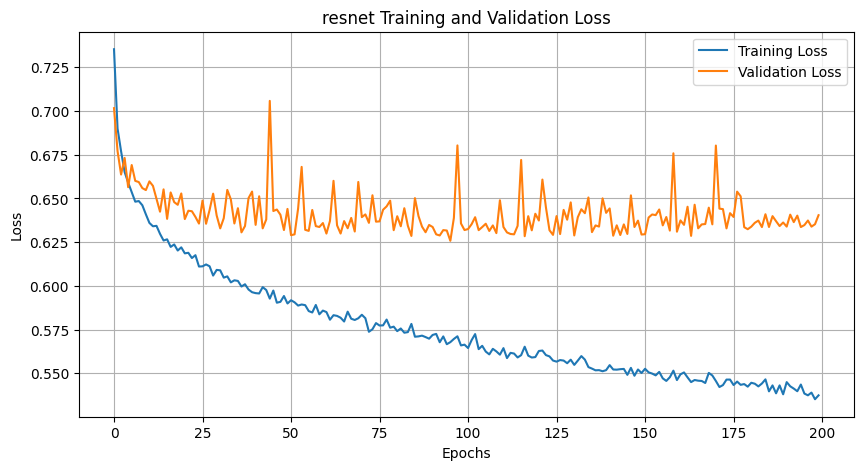

In [ ]:
plot_loss_curves('resnet', '/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/resnet_metrics.csv')

### EfficientNet

In [ ]:
pip install --upgrade torch torchvision

In [ ]:
#get_precomputed_features_loader('efficientnet', data_loaders, save_model_dir, device)
efficientnet_feature_loaders = load_saved_features('efficientnet',save_model_dir)

In [ ]:
efficientnet_model,efficientnet_log = train_classifier('efficientnet', efficientnet_feature_loaders, total_epochs=200, num_classes=3, save_dir =save_log_dir)

Epoch 1/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 597.19it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 1 - Train Loss: 0.7063, Train Acc: 0.73%, Valid Loss: 0.6526, Valid Acc: 0.74%


Epoch 2/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 852.07it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 2 - Train Loss: 0.6594, Train Acc: 0.74%, Valid Loss: 0.6398, Valid Acc: 0.75%


Epoch 3/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 934.39it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 3 - Train Loss: 0.6417, Train Acc: 0.75%, Valid Loss: 0.6279, Valid Acc: 0.75%


Epoch 4/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 999.05it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 4 - Train Loss: 0.6319, Train Acc: 0.75%, Valid Loss: 0.6189, Valid Acc: 0.76%


Epoch 5/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 971.90it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 5 - Train Loss: 0.6238, Train Acc: 0.75%, Valid Loss: 0.6171, Valid Acc: 0.76%


Epoch 6/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 721.72it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 6 - Train Loss: 0.6163, Train Acc: 0.75%, Valid Loss: 0.6107, Valid Acc: 0.76%


Epoch 7/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 684.18it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 7 - Train Loss: 0.6118, Train Acc: 0.75%, Valid Loss: 0.6090, Valid Acc: 0.76%


Epoch 8/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 665.92it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 8 - Train Loss: 0.6065, Train Acc: 0.76%, Valid Loss: 0.6130, Valid Acc: 0.76%


Epoch 9/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 605.94it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 9 - Train Loss: 0.6039, Train Acc: 0.76%, Valid Loss: 0.6086, Valid Acc: 0.76%


Epoch 10/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 669.82it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 10 - Train Loss: 0.6004, Train Acc: 0.76%, Valid Loss: 0.6080, Valid Acc: 0.76%


Epoch 11/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 683.23it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 11 - Train Loss: 0.5941, Train Acc: 0.76%, Valid Loss: 0.6030, Valid Acc: 0.76%


Epoch 12/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 753.29it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 12 - Train Loss: 0.5934, Train Acc: 0.76%, Valid Loss: 0.6037, Valid Acc: 0.76%


Epoch 13/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 609.18it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 13 - Train Loss: 0.5917, Train Acc: 0.76%, Valid Loss: 0.6008, Valid Acc: 0.76%


Epoch 14/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 983.49it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 14 - Train Loss: 0.5881, Train Acc: 0.76%, Valid Loss: 0.5994, Valid Acc: 0.76%


Epoch 15/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 1017.59it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 15 - Train Loss: 0.5865, Train Acc: 0.76%, Valid Loss: 0.6025, Valid Acc: 0.76%


Epoch 16/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 940.89it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 16 - Train Loss: 0.5839, Train Acc: 0.76%, Valid Loss: 0.6014, Valid Acc: 0.76%


Epoch 17/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 962.99it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 17 - Train Loss: 0.5816, Train Acc: 0.76%, Valid Loss: 0.5981, Valid Acc: 0.76%


Epoch 18/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 866.77it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 18 - Train Loss: 0.5784, Train Acc: 0.76%, Valid Loss: 0.5972, Valid Acc: 0.76%


Epoch 19/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 961.39it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 19 - Train Loss: 0.5775, Train Acc: 0.76%, Valid Loss: 0.6016, Valid Acc: 0.76%


Epoch 20/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 920.07it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 20 - Train Loss: 0.5773, Train Acc: 0.76%, Valid Loss: 0.5971, Valid Acc: 0.76%


Epoch 21/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 979.49it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 21 - Train Loss: 0.5743, Train Acc: 0.77%, Valid Loss: 0.5999, Valid Acc: 0.76%


Epoch 22/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 987.40it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 22 - Train Loss: 0.5738, Train Acc: 0.77%, Valid Loss: 0.6017, Valid Acc: 0.76%


Epoch 23/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 989.33it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 23 - Train Loss: 0.5720, Train Acc: 0.77%, Valid Loss: 0.5968, Valid Acc: 0.76%


Epoch 24/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 981.58it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 24 - Train Loss: 0.5702, Train Acc: 0.77%, Valid Loss: 0.5967, Valid Acc: 0.76%


Epoch 25/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 988.96it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 25 - Train Loss: 0.5681, Train Acc: 0.77%, Valid Loss: 0.5991, Valid Acc: 0.76%


Epoch 26/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 953.66it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 26 - Train Loss: 0.5674, Train Acc: 0.77%, Valid Loss: 0.6044, Valid Acc: 0.75%


Epoch 27/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 987.86it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 27 - Train Loss: 0.5675, Train Acc: 0.77%, Valid Loss: 0.5963, Valid Acc: 0.76%


Epoch 28/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 957.56it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 28 - Train Loss: 0.5645, Train Acc: 0.77%, Valid Loss: 0.5978, Valid Acc: 0.76%


Epoch 29/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 881.68it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 29 - Train Loss: 0.5642, Train Acc: 0.77%, Valid Loss: 0.5954, Valid Acc: 0.76%


Epoch 30/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 958.53it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 30 - Train Loss: 0.5628, Train Acc: 0.77%, Valid Loss: 0.5961, Valid Acc: 0.76%


Epoch 31/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 977.51it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 31 - Train Loss: 0.5603, Train Acc: 0.77%, Valid Loss: 0.5948, Valid Acc: 0.76%


Epoch 32/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 601.08it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 32 - Train Loss: 0.5598, Train Acc: 0.77%, Valid Loss: 0.6001, Valid Acc: 0.76%


Epoch 33/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 699.63it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 33 - Train Loss: 0.5623, Train Acc: 0.77%, Valid Loss: 0.5984, Valid Acc: 0.76%


Epoch 34/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 714.77it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 34 - Train Loss: 0.5586, Train Acc: 0.77%, Valid Loss: 0.5959, Valid Acc: 0.77%


Epoch 35/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 623.21it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 35 - Train Loss: 0.5570, Train Acc: 0.77%, Valid Loss: 0.5958, Valid Acc: 0.76%


Epoch 36/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 710.36it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 36 - Train Loss: 0.5559, Train Acc: 0.77%, Valid Loss: 0.5955, Valid Acc: 0.76%


Epoch 37/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 695.30it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 37 - Train Loss: 0.5556, Train Acc: 0.77%, Valid Loss: 0.6073, Valid Acc: 0.75%


Epoch 38/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 707.77it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 38 - Train Loss: 0.5537, Train Acc: 0.77%, Valid Loss: 0.5971, Valid Acc: 0.76%


Epoch 39/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 708.01it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 39 - Train Loss: 0.5540, Train Acc: 0.77%, Valid Loss: 0.5974, Valid Acc: 0.76%


Epoch 40/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 982.66it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 40 - Train Loss: 0.5528, Train Acc: 0.77%, Valid Loss: 0.5957, Valid Acc: 0.76%


Epoch 41/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 1006.26it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 41 - Train Loss: 0.5503, Train Acc: 0.78%, Valid Loss: 0.6088, Valid Acc: 0.76%


Epoch 42/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 873.37it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 42 - Train Loss: 0.5513, Train Acc: 0.78%, Valid Loss: 0.5971, Valid Acc: 0.76%


Epoch 43/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 950.69it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 43 - Train Loss: 0.5511, Train Acc: 0.78%, Valid Loss: 0.5974, Valid Acc: 0.76%


Epoch 44/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 1006.62it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 44 - Train Loss: 0.5497, Train Acc: 0.78%, Valid Loss: 0.5963, Valid Acc: 0.76%


Epoch 45/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 992.98it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 45 - Train Loss: 0.5490, Train Acc: 0.78%, Valid Loss: 0.5983, Valid Acc: 0.76%


Epoch 46/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 954.66it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 46 - Train Loss: 0.5488, Train Acc: 0.78%, Valid Loss: 0.5976, Valid Acc: 0.76%


Epoch 47/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 955.94it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 47 - Train Loss: 0.5486, Train Acc: 0.78%, Valid Loss: 0.6006, Valid Acc: 0.76%


Epoch 48/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 836.06it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 48 - Train Loss: 0.5465, Train Acc: 0.78%, Valid Loss: 0.5974, Valid Acc: 0.76%


Epoch 49/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 949.94it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 49 - Train Loss: 0.5461, Train Acc: 0.78%, Valid Loss: 0.5973, Valid Acc: 0.76%


Epoch 50/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 1007.16it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 50 - Train Loss: 0.5447, Train Acc: 0.78%, Valid Loss: 0.5979, Valid Acc: 0.76%


Epoch 51/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 897.47it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 51 - Train Loss: 0.5438, Train Acc: 0.78%, Valid Loss: 0.6008, Valid Acc: 0.76%


Epoch 52/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 935.88it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 52 - Train Loss: 0.5443, Train Acc: 0.78%, Valid Loss: 0.5963, Valid Acc: 0.76%


Epoch 53/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 851.51it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 53 - Train Loss: 0.5435, Train Acc: 0.78%, Valid Loss: 0.5971, Valid Acc: 0.76%


Epoch 54/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 860.85it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 54 - Train Loss: 0.5436, Train Acc: 0.78%, Valid Loss: 0.5985, Valid Acc: 0.76%


Epoch 55/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 884.28it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 55 - Train Loss: 0.5415, Train Acc: 0.78%, Valid Loss: 0.5980, Valid Acc: 0.76%


Epoch 56/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 826.04it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 56 - Train Loss: 0.5412, Train Acc: 0.78%, Valid Loss: 0.5975, Valid Acc: 0.76%


Epoch 57/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 548.54it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 57 - Train Loss: 0.5402, Train Acc: 0.78%, Valid Loss: 0.5997, Valid Acc: 0.76%


Epoch 58/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 540.26it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 58 - Train Loss: 0.5404, Train Acc: 0.78%, Valid Loss: 0.6036, Valid Acc: 0.75%


Epoch 59/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 625.21it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 59 - Train Loss: 0.5397, Train Acc: 0.78%, Valid Loss: 0.6025, Valid Acc: 0.77%


Epoch 60/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 717.11it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 60 - Train Loss: 0.5400, Train Acc: 0.78%, Valid Loss: 0.6007, Valid Acc: 0.77%


Epoch 61/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 710.34it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 61 - Train Loss: 0.5396, Train Acc: 0.78%, Valid Loss: 0.6039, Valid Acc: 0.77%


Epoch 62/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 690.72it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 62 - Train Loss: 0.5387, Train Acc: 0.78%, Valid Loss: 0.6004, Valid Acc: 0.75%


Epoch 63/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 690.36it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 63 - Train Loss: 0.5389, Train Acc: 0.78%, Valid Loss: 0.5994, Valid Acc: 0.76%


Epoch 64/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 675.52it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 64 - Train Loss: 0.5370, Train Acc: 0.78%, Valid Loss: 0.6055, Valid Acc: 0.75%


Epoch 65/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 729.69it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 65 - Train Loss: 0.5390, Train Acc: 0.78%, Valid Loss: 0.6078, Valid Acc: 0.75%


Epoch 66/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 983.78it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 66 - Train Loss: 0.5380, Train Acc: 0.78%, Valid Loss: 0.5989, Valid Acc: 0.76%


Epoch 67/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 953.97it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 67 - Train Loss: 0.5367, Train Acc: 0.78%, Valid Loss: 0.6071, Valid Acc: 0.75%


Epoch 68/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 934.91it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 68 - Train Loss: 0.5371, Train Acc: 0.78%, Valid Loss: 0.6019, Valid Acc: 0.75%


Epoch 69/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 883.61it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 69 - Train Loss: 0.5349, Train Acc: 0.78%, Valid Loss: 0.6026, Valid Acc: 0.76%


Epoch 70/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 810.94it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 70 - Train Loss: 0.5363, Train Acc: 0.78%, Valid Loss: 0.6178, Valid Acc: 0.74%


Epoch 71/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 903.09it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 71 - Train Loss: 0.5336, Train Acc: 0.78%, Valid Loss: 0.6009, Valid Acc: 0.76%


Epoch 72/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 888.00it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 72 - Train Loss: 0.5339, Train Acc: 0.78%, Valid Loss: 0.6017, Valid Acc: 0.75%


Epoch 73/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 919.08it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 73 - Train Loss: 0.5323, Train Acc: 0.78%, Valid Loss: 0.6010, Valid Acc: 0.76%


Epoch 74/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 992.28it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 74 - Train Loss: 0.5348, Train Acc: 0.78%, Valid Loss: 0.6036, Valid Acc: 0.76%


Epoch 75/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 777.73it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 75 - Train Loss: 0.5330, Train Acc: 0.78%, Valid Loss: 0.6011, Valid Acc: 0.76%


Epoch 76/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 1013.07it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 76 - Train Loss: 0.5321, Train Acc: 0.78%, Valid Loss: 0.6108, Valid Acc: 0.74%


Epoch 77/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 850.03it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 77 - Train Loss: 0.5316, Train Acc: 0.78%, Valid Loss: 0.6006, Valid Acc: 0.76%


Epoch 78/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 988.27it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 78 - Train Loss: 0.5311, Train Acc: 0.78%, Valid Loss: 0.6045, Valid Acc: 0.75%


Epoch 79/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 982.79it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 79 - Train Loss: 0.5330, Train Acc: 0.78%, Valid Loss: 0.6065, Valid Acc: 0.75%


Epoch 80/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 828.21it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 80 - Train Loss: 0.5318, Train Acc: 0.78%, Valid Loss: 0.6079, Valid Acc: 0.75%


Epoch 81/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 955.50it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 81 - Train Loss: 0.5312, Train Acc: 0.78%, Valid Loss: 0.6015, Valid Acc: 0.76%


Epoch 82/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 563.09it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 82 - Train Loss: 0.5316, Train Acc: 0.78%, Valid Loss: 0.6266, Valid Acc: 0.73%


Epoch 83/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 689.59it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 83 - Train Loss: 0.5306, Train Acc: 0.78%, Valid Loss: 0.6025, Valid Acc: 0.76%


Epoch 84/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 601.28it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 84 - Train Loss: 0.5307, Train Acc: 0.78%, Valid Loss: 0.6035, Valid Acc: 0.76%


Epoch 85/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 578.55it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 85 - Train Loss: 0.5288, Train Acc: 0.78%, Valid Loss: 0.6058, Valid Acc: 0.75%


Epoch 86/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 575.92it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 86 - Train Loss: 0.5279, Train Acc: 0.78%, Valid Loss: 0.6050, Valid Acc: 0.76%


Epoch 87/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 601.99it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 87 - Train Loss: 0.5287, Train Acc: 0.78%, Valid Loss: 0.6023, Valid Acc: 0.76%


Epoch 88/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 591.35it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 88 - Train Loss: 0.5285, Train Acc: 0.79%, Valid Loss: 0.6031, Valid Acc: 0.75%


Epoch 89/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 690.76it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 89 - Train Loss: 0.5283, Train Acc: 0.79%, Valid Loss: 0.6044, Valid Acc: 0.75%


Epoch 90/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 715.06it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 90 - Train Loss: 0.5287, Train Acc: 0.79%, Valid Loss: 0.6149, Valid Acc: 0.74%


Epoch 91/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 959.45it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 91 - Train Loss: 0.5291, Train Acc: 0.79%, Valid Loss: 0.6071, Valid Acc: 0.75%


Epoch 92/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 1019.45it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 92 - Train Loss: 0.5262, Train Acc: 0.79%, Valid Loss: 0.6050, Valid Acc: 0.76%


Epoch 93/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 886.46it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 93 - Train Loss: 0.5272, Train Acc: 0.78%, Valid Loss: 0.6062, Valid Acc: 0.75%


Epoch 94/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 1027.96it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 94 - Train Loss: 0.5248, Train Acc: 0.79%, Valid Loss: 0.6044, Valid Acc: 0.76%


Epoch 95/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 978.89it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 95 - Train Loss: 0.5259, Train Acc: 0.79%, Valid Loss: 0.6076, Valid Acc: 0.76%


Epoch 96/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 977.49it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 96 - Train Loss: 0.5246, Train Acc: 0.79%, Valid Loss: 0.6065, Valid Acc: 0.76%


Epoch 97/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 990.03it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 97 - Train Loss: 0.5274, Train Acc: 0.78%, Valid Loss: 0.6055, Valid Acc: 0.76%


Epoch 98/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 961.22it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 98 - Train Loss: 0.5254, Train Acc: 0.79%, Valid Loss: 0.6040, Valid Acc: 0.76%


Epoch 99/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 955.10it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 99 - Train Loss: 0.5247, Train Acc: 0.79%, Valid Loss: 0.6159, Valid Acc: 0.74%


Epoch 100/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 980.17it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 100 - Train Loss: 0.5243, Train Acc: 0.79%, Valid Loss: 0.6054, Valid Acc: 0.76%


Epoch 101/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 999.97it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 101 - Train Loss: 0.5247, Train Acc: 0.79%, Valid Loss: 0.6094, Valid Acc: 0.75%


Epoch 102/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 952.63it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 102 - Train Loss: 0.5239, Train Acc: 0.79%, Valid Loss: 0.6072, Valid Acc: 0.76%


Epoch 103/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 950.86it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 103 - Train Loss: 0.5249, Train Acc: 0.78%, Valid Loss: 0.6052, Valid Acc: 0.76%


Epoch 104/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 925.16it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 104 - Train Loss: 0.5220, Train Acc: 0.79%, Valid Loss: 0.6107, Valid Acc: 0.75%


Epoch 105/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 958.69it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 105 - Train Loss: 0.5231, Train Acc: 0.79%, Valid Loss: 0.6076, Valid Acc: 0.76%


Epoch 106/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 940.97it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 106 - Train Loss: 0.5237, Train Acc: 0.79%, Valid Loss: 0.6052, Valid Acc: 0.76%


Epoch 107/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 928.51it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 107 - Train Loss: 0.5224, Train Acc: 0.79%, Valid Loss: 0.6230, Valid Acc: 0.73%


Epoch 108/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 697.58it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 108 - Train Loss: 0.5224, Train Acc: 0.79%, Valid Loss: 0.6087, Valid Acc: 0.75%


Epoch 109/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 731.45it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 109 - Train Loss: 0.5219, Train Acc: 0.79%, Valid Loss: 0.6116, Valid Acc: 0.75%


Epoch 110/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 622.57it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 110 - Train Loss: 0.5215, Train Acc: 0.79%, Valid Loss: 0.6066, Valid Acc: 0.75%


Epoch 111/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 670.35it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 111 - Train Loss: 0.5204, Train Acc: 0.79%, Valid Loss: 0.6099, Valid Acc: 0.76%


Epoch 112/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 564.02it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 112 - Train Loss: 0.5204, Train Acc: 0.79%, Valid Loss: 0.6093, Valid Acc: 0.76%


Epoch 113/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 670.13it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 113 - Train Loss: 0.5198, Train Acc: 0.79%, Valid Loss: 0.6065, Valid Acc: 0.76%


Epoch 114/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 680.86it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 114 - Train Loss: 0.5191, Train Acc: 0.79%, Valid Loss: 0.6097, Valid Acc: 0.75%


Epoch 115/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 746.97it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 115 - Train Loss: 0.5206, Train Acc: 0.79%, Valid Loss: 0.6070, Valid Acc: 0.76%


Epoch 116/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 625.51it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 116 - Train Loss: 0.5205, Train Acc: 0.79%, Valid Loss: 0.6116, Valid Acc: 0.75%


Epoch 117/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 935.51it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 117 - Train Loss: 0.5195, Train Acc: 0.79%, Valid Loss: 0.6112, Valid Acc: 0.75%


Epoch 118/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 884.01it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 118 - Train Loss: 0.5190, Train Acc: 0.79%, Valid Loss: 0.6120, Valid Acc: 0.76%


Epoch 119/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 1000.81it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 119 - Train Loss: 0.5194, Train Acc: 0.79%, Valid Loss: 0.6107, Valid Acc: 0.75%


Epoch 120/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 957.11it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 120 - Train Loss: 0.5205, Train Acc: 0.79%, Valid Loss: 0.6135, Valid Acc: 0.75%


Epoch 121/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 945.33it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 121 - Train Loss: 0.5188, Train Acc: 0.79%, Valid Loss: 0.6099, Valid Acc: 0.75%


Epoch 122/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 876.60it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 122 - Train Loss: 0.5184, Train Acc: 0.79%, Valid Loss: 0.6130, Valid Acc: 0.75%


Epoch 123/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 917.44it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 123 - Train Loss: 0.5179, Train Acc: 0.79%, Valid Loss: 0.6100, Valid Acc: 0.75%


Epoch 124/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 710.83it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 124 - Train Loss: 0.5173, Train Acc: 0.79%, Valid Loss: 0.6145, Valid Acc: 0.75%


Epoch 125/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 834.60it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 125 - Train Loss: 0.5188, Train Acc: 0.79%, Valid Loss: 0.6088, Valid Acc: 0.76%


Epoch 126/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 888.69it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 126 - Train Loss: 0.5190, Train Acc: 0.79%, Valid Loss: 0.6105, Valid Acc: 0.76%


Epoch 127/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 922.19it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 127 - Train Loss: 0.5177, Train Acc: 0.79%, Valid Loss: 0.6157, Valid Acc: 0.76%


Epoch 128/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 839.23it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 128 - Train Loss: 0.5177, Train Acc: 0.79%, Valid Loss: 0.6134, Valid Acc: 0.76%


Epoch 129/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 874.99it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 129 - Train Loss: 0.5166, Train Acc: 0.79%, Valid Loss: 0.6122, Valid Acc: 0.75%


Epoch 130/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 1002.37it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 130 - Train Loss: 0.5177, Train Acc: 0.79%, Valid Loss: 0.6105, Valid Acc: 0.76%


Epoch 131/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 938.19it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 131 - Train Loss: 0.5176, Train Acc: 0.79%, Valid Loss: 0.6099, Valid Acc: 0.75%


Epoch 132/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 972.18it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 132 - Train Loss: 0.5163, Train Acc: 0.79%, Valid Loss: 0.6144, Valid Acc: 0.75%


Epoch 133/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 562.79it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 133 - Train Loss: 0.5164, Train Acc: 0.79%, Valid Loss: 0.6107, Valid Acc: 0.75%


Epoch 134/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 632.98it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 134 - Train Loss: 0.5168, Train Acc: 0.79%, Valid Loss: 0.6110, Valid Acc: 0.76%


Epoch 135/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 694.07it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 135 - Train Loss: 0.5174, Train Acc: 0.79%, Valid Loss: 0.6106, Valid Acc: 0.76%


Epoch 136/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 650.63it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 136 - Train Loss: 0.5155, Train Acc: 0.79%, Valid Loss: 0.6176, Valid Acc: 0.75%


Epoch 137/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 616.66it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 137 - Train Loss: 0.5161, Train Acc: 0.79%, Valid Loss: 0.6129, Valid Acc: 0.75%


Epoch 138/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 597.60it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 138 - Train Loss: 0.5153, Train Acc: 0.79%, Valid Loss: 0.6132, Valid Acc: 0.75%


Epoch 139/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 683.40it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 139 - Train Loss: 0.5155, Train Acc: 0.79%, Valid Loss: 0.6162, Valid Acc: 0.75%


Epoch 140/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 676.18it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 140 - Train Loss: 0.5155, Train Acc: 0.79%, Valid Loss: 0.6137, Valid Acc: 0.76%


Epoch 141/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 721.86it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 141 - Train Loss: 0.5145, Train Acc: 0.79%, Valid Loss: 0.6137, Valid Acc: 0.75%


Epoch 142/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 989.84it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 142 - Train Loss: 0.5147, Train Acc: 0.79%, Valid Loss: 0.6131, Valid Acc: 0.75%


Epoch 143/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 887.24it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 143 - Train Loss: 0.5152, Train Acc: 0.79%, Valid Loss: 0.6140, Valid Acc: 0.75%


Epoch 144/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 951.08it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 144 - Train Loss: 0.5147, Train Acc: 0.79%, Valid Loss: 0.6150, Valid Acc: 0.76%


Epoch 145/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 906.67it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 145 - Train Loss: 0.5136, Train Acc: 0.79%, Valid Loss: 0.6174, Valid Acc: 0.75%


Epoch 146/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 849.41it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 146 - Train Loss: 0.5136, Train Acc: 0.79%, Valid Loss: 0.6174, Valid Acc: 0.74%


Epoch 147/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 929.94it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 147 - Train Loss: 0.5141, Train Acc: 0.79%, Valid Loss: 0.6164, Valid Acc: 0.74%


Epoch 148/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 869.25it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 148 - Train Loss: 0.5146, Train Acc: 0.79%, Valid Loss: 0.6159, Valid Acc: 0.75%


Epoch 149/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 903.48it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 149 - Train Loss: 0.5139, Train Acc: 0.79%, Valid Loss: 0.6137, Valid Acc: 0.75%


Epoch 150/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 915.17it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 150 - Train Loss: 0.5127, Train Acc: 0.79%, Valid Loss: 0.6168, Valid Acc: 0.76%


Epoch 151/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 1016.66it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 151 - Train Loss: 0.5158, Train Acc: 0.79%, Valid Loss: 0.6140, Valid Acc: 0.76%


Epoch 152/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 967.73it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 152 - Train Loss: 0.5124, Train Acc: 0.79%, Valid Loss: 0.6184, Valid Acc: 0.74%


Epoch 153/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 863.18it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 153 - Train Loss: 0.5140, Train Acc: 0.79%, Valid Loss: 0.6139, Valid Acc: 0.75%


Epoch 154/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 923.48it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 154 - Train Loss: 0.5126, Train Acc: 0.79%, Valid Loss: 0.6170, Valid Acc: 0.74%


Epoch 155/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 940.01it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 155 - Train Loss: 0.5140, Train Acc: 0.79%, Valid Loss: 0.6200, Valid Acc: 0.74%


Epoch 156/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 937.31it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 156 - Train Loss: 0.5128, Train Acc: 0.79%, Valid Loss: 0.6164, Valid Acc: 0.76%


Epoch 157/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 949.22it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 157 - Train Loss: 0.5127, Train Acc: 0.79%, Valid Loss: 0.6153, Valid Acc: 0.75%


Epoch 158/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 1005.08it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 158 - Train Loss: 0.5109, Train Acc: 0.79%, Valid Loss: 0.6154, Valid Acc: 0.75%


Epoch 159/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 710.14it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 159 - Train Loss: 0.5112, Train Acc: 0.79%, Valid Loss: 0.6146, Valid Acc: 0.75%


Epoch 160/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 609.85it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 160 - Train Loss: 0.5125, Train Acc: 0.79%, Valid Loss: 0.6214, Valid Acc: 0.74%


Epoch 161/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 513.38it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 161 - Train Loss: 0.5128, Train Acc: 0.79%, Valid Loss: 0.6165, Valid Acc: 0.76%


Epoch 162/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 687.97it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 162 - Train Loss: 0.5117, Train Acc: 0.79%, Valid Loss: 0.6165, Valid Acc: 0.76%


Epoch 163/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 664.71it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 163 - Train Loss: 0.5103, Train Acc: 0.79%, Valid Loss: 0.6150, Valid Acc: 0.75%


Epoch 164/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 633.06it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 164 - Train Loss: 0.5121, Train Acc: 0.79%, Valid Loss: 0.6283, Valid Acc: 0.74%


Epoch 165/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 541.79it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 165 - Train Loss: 0.5115, Train Acc: 0.79%, Valid Loss: 0.6169, Valid Acc: 0.75%


Epoch 166/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 566.64it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 166 - Train Loss: 0.5110, Train Acc: 0.79%, Valid Loss: 0.6176, Valid Acc: 0.75%


Epoch 167/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 711.82it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 167 - Train Loss: 0.5117, Train Acc: 0.79%, Valid Loss: 0.6233, Valid Acc: 0.74%


Epoch 168/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 910.91it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 168 - Train Loss: 0.5091, Train Acc: 0.79%, Valid Loss: 0.6164, Valid Acc: 0.76%


Epoch 169/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 870.06it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 169 - Train Loss: 0.5103, Train Acc: 0.79%, Valid Loss: 0.6156, Valid Acc: 0.75%


Epoch 170/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 893.10it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 170 - Train Loss: 0.5102, Train Acc: 0.79%, Valid Loss: 0.6326, Valid Acc: 0.73%


Epoch 171/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 840.97it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 171 - Train Loss: 0.5103, Train Acc: 0.79%, Valid Loss: 0.6185, Valid Acc: 0.75%


Epoch 172/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 917.89it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 172 - Train Loss: 0.5095, Train Acc: 0.79%, Valid Loss: 0.6182, Valid Acc: 0.75%


Epoch 173/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 961.63it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 173 - Train Loss: 0.5102, Train Acc: 0.79%, Valid Loss: 0.6221, Valid Acc: 0.76%


Epoch 174/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 934.28it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 174 - Train Loss: 0.5100, Train Acc: 0.79%, Valid Loss: 0.6211, Valid Acc: 0.75%


Epoch 175/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 952.07it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 175 - Train Loss: 0.5098, Train Acc: 0.79%, Valid Loss: 0.6174, Valid Acc: 0.75%


Epoch 176/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 973.83it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 176 - Train Loss: 0.5092, Train Acc: 0.79%, Valid Loss: 0.6279, Valid Acc: 0.74%


Epoch 177/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 997.04it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 177 - Train Loss: 0.5090, Train Acc: 0.79%, Valid Loss: 0.6171, Valid Acc: 0.75%


Epoch 178/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 1013.29it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 178 - Train Loss: 0.5086, Train Acc: 0.79%, Valid Loss: 0.6178, Valid Acc: 0.74%


Epoch 179/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 962.04it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 179 - Train Loss: 0.5085, Train Acc: 0.79%, Valid Loss: 0.6187, Valid Acc: 0.75%


Epoch 180/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 878.90it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 180 - Train Loss: 0.5092, Train Acc: 0.79%, Valid Loss: 0.6176, Valid Acc: 0.75%


Epoch 181/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 914.93it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 181 - Train Loss: 0.5088, Train Acc: 0.79%, Valid Loss: 0.6202, Valid Acc: 0.75%


Epoch 182/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 830.23it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 182 - Train Loss: 0.5082, Train Acc: 0.79%, Valid Loss: 0.6202, Valid Acc: 0.75%


Epoch 183/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 923.25it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 183 - Train Loss: 0.5078, Train Acc: 0.79%, Valid Loss: 0.6224, Valid Acc: 0.74%


Epoch 184/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 608.14it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 184 - Train Loss: 0.5079, Train Acc: 0.79%, Valid Loss: 0.6187, Valid Acc: 0.75%


Epoch 185/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 701.69it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 185 - Train Loss: 0.5068, Train Acc: 0.79%, Valid Loss: 0.6212, Valid Acc: 0.76%


Epoch 186/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 717.78it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 186 - Train Loss: 0.5083, Train Acc: 0.79%, Valid Loss: 0.6208, Valid Acc: 0.76%


Epoch 187/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 673.60it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 187 - Train Loss: 0.5078, Train Acc: 0.79%, Valid Loss: 0.6203, Valid Acc: 0.75%


Epoch 188/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 668.38it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 188 - Train Loss: 0.5085, Train Acc: 0.79%, Valid Loss: 0.6235, Valid Acc: 0.76%


Epoch 189/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 740.51it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 189 - Train Loss: 0.5075, Train Acc: 0.79%, Valid Loss: 0.6261, Valid Acc: 0.74%


Epoch 190/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 649.06it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 190 - Train Loss: 0.5090, Train Acc: 0.79%, Valid Loss: 0.6215, Valid Acc: 0.75%


Epoch 191/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 611.04it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 191 - Train Loss: 0.5073, Train Acc: 0.79%, Valid Loss: 0.6200, Valid Acc: 0.75%


Epoch 192/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 594.46it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 192 - Train Loss: 0.5072, Train Acc: 0.79%, Valid Loss: 0.6234, Valid Acc: 0.76%


Epoch 193/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 1003.29it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 193 - Train Loss: 0.5075, Train Acc: 0.79%, Valid Loss: 0.6209, Valid Acc: 0.75%


Epoch 194/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 931.74it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 194 - Train Loss: 0.5081, Train Acc: 0.79%, Valid Loss: 0.6206, Valid Acc: 0.75%


Epoch 195/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 927.77it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 195 - Train Loss: 0.5070, Train Acc: 0.79%, Valid Loss: 0.6232, Valid Acc: 0.76%


Epoch 196/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 952.48it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 196 - Train Loss: 0.5072, Train Acc: 0.79%, Valid Loss: 0.6204, Valid Acc: 0.75%


Epoch 197/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 983.07it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 197 - Train Loss: 0.5073, Train Acc: 0.79%, Valid Loss: 0.6232, Valid Acc: 0.75%


Epoch 198/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 897.11it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 198 - Train Loss: 0.5094, Train Acc: 0.79%, Valid Loss: 0.6253, Valid Acc: 0.74%


Epoch 199/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 978.84it/s]
<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 199 - Train Loss: 0.5068, Train Acc: 0.79%, Valid Loss: 0.6222, Valid Acc: 0.75%


Epoch 200/200 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 983.41it/s]

Epoch 200 - Train Loss: 0.5061, Train Acc: 0.79%, Valid Loss: 0.6207, Valid Acc: 0.75%
Training completed. Metrics logged to /content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/efficientnet_metrics.csv.



<ipython-input-17-a7187e0bcb8b>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


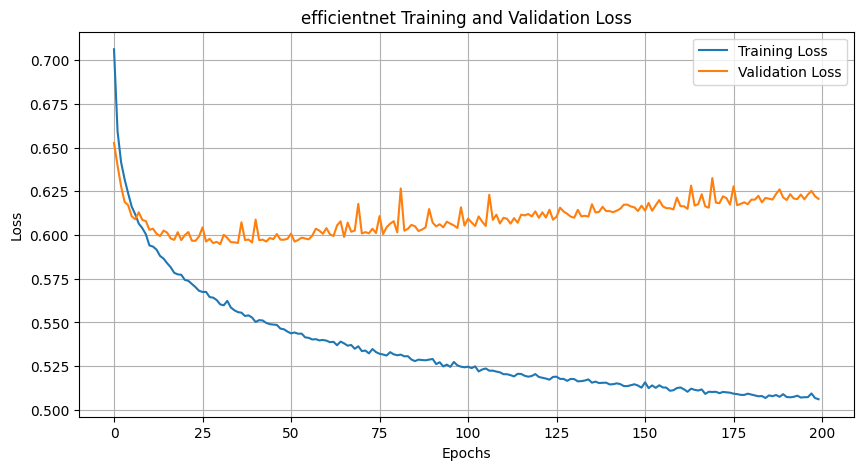

In [ ]:
plot_loss_curves('efficientnet', '/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/efficientnet_metrics.csv')

### Model Comparison

## Finetune model

In [ ]:
def train_pretrained_model(model_name, data_loader, freeze = False, total_epochs = 10, save_dir = '', num_classes = 3):
    # Load the appropriate pretrained model
    if model_name == 'vgg':
        model = models.vgg19(pretrained=True)
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnet':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'efficientnet':
        model = models.efficientnet_b0(pretrained=True)
    else:
        raise ValueError(f'Unknown model name: {model_name}')

    # Freeze half of the layers if freeze is True
    if freeze:
        child_counter = 0
        for child in model.children():
            if child_counter < len(list(model.children())) // 2:
                for param in child.parameters():
                    param.requires_grad = False
            else:
                break
            child_counter += 1

    # Prepare model, loss function, optimizer
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005, weight_decay=1e-4)

    train_loader = data_loader['train']
    valid_loader = data_loader['valid']

    # Determine CSV file name
    csv_file_suffix = 'freeze_train_metrics.csv' if freeze else 'full_train_metrics.csv'
    csv_file_path = os.path.join(save_dir, f'{model_name}_{csv_file_suffix}')

    # Prepare DataFrame to store losses and accuracies
    log_df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])

    for epoch in range(total_epochs):
        # Initialize metrics
        train_loss, train_correct, train_total = 0.0, 0, 0
        valid_loss, valid_correct, valid_total = 0.0, 0, 0

        # Training Phase
        model.train()
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{total_epochs} [Training]'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels.data)
            train_total += labels.size(0)

        # Validation Phase
        model.eval()
        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc=f'Epoch {epoch+1}/{total_epochs} [Validation]'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                valid_correct += torch.sum(preds == labels.data)
                valid_total += labels.size(0)

        # Calculate average loss and accuracy
        avg_train_loss = train_loss / len(data_loader['train'])
        avg_train_acc = train_correct.double() / train_total
        avg_valid_loss = valid_loss / len(data_loader['valid'])
        avg_valid_acc = valid_correct.double() / valid_total

         # Print average losses for the epoch
        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {avg_valid_acc:.2f}%")

        # Append metrics to DataFrame
        log_df = log_df.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_accuracy': avg_train_acc.item(),
            'valid_loss': avg_valid_loss,
            'valid_accuracy': avg_valid_acc.item()
        }, ignore_index=True)

        # Save DataFrame to CSV file
        log_df.to_csv(csv_file_path, index=False)

    print(f"Training completed. Metrics logged to {csv_file_path}.")
    return model,log_df

### VGG

In [ ]:
vgg_freeze_model,vgg_freeze_log = train_pretrained_model('vgg', data_loaders, freeze = True, total_epochs = 10, save_dir = save_log_dir)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Validation]: 100%|██████████| 34/34 [00:32<00:00,  1.05it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 1 - Train Loss: 0.7505, Train Acc: 0.72%, Valid Loss: 0.6318, Valid Acc: 0.76%


Epoch 2/10 [Validation]: 100%|██████████| 34/34 [00:32<00:00,  1.05it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 2 - Train Loss: 0.6339, Train Acc: 0.75%, Valid Loss: 0.6826, Valid Acc: 0.75%


Epoch 3/10 [Validation]: 100%|██████████| 34/34 [00:31<00:00,  1.07it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 3 - Train Loss: 0.5984, Train Acc: 0.76%, Valid Loss: 0.6125, Valid Acc: 0.77%


Epoch 4/10 [Validation]: 100%|██████████| 34/34 [00:32<00:00,  1.06it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 4 - Train Loss: 0.5586, Train Acc: 0.77%, Valid Loss: 0.5912, Valid Acc: 0.77%


Epoch 5/10 [Validation]: 100%|██████████| 34/34 [00:32<00:00,  1.06it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 5 - Train Loss: 0.5367, Train Acc: 0.78%, Valid Loss: 0.5789, Valid Acc: 0.77%


Epoch 6/10 [Validation]: 100%|██████████| 34/34 [00:30<00:00,  1.11it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 6 - Train Loss: 0.5101, Train Acc: 0.79%, Valid Loss: 0.5791, Valid Acc: 0.77%


Epoch 7/10 [Validation]: 100%|██████████| 34/34 [00:31<00:00,  1.06it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 7 - Train Loss: 0.4893, Train Acc: 0.79%, Valid Loss: 0.5911, Valid Acc: 0.77%


Epoch 8/10 [Validation]: 100%|██████████| 34/34 [00:31<00:00,  1.06it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 8 - Train Loss: 0.4637, Train Acc: 0.81%, Valid Loss: 0.6034, Valid Acc: 0.77%


Epoch 9/10 [Validation]: 100%|██████████| 34/34 [00:30<00:00,  1.11it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 9 - Train Loss: 0.4413, Train Acc: 0.82%, Valid Loss: 0.6296, Valid Acc: 0.75%


Epoch 10/10 [Validation]: 100%|██████████| 34/34 [00:32<00:00,  1.06it/s]

Epoch 10 - Train Loss: 0.4204, Train Acc: 0.82%, Valid Loss: 0.6894, Valid Acc: 0.78%
Training completed. Metrics logged to /content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/vgg_freeze_train_metrics.csv.



<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


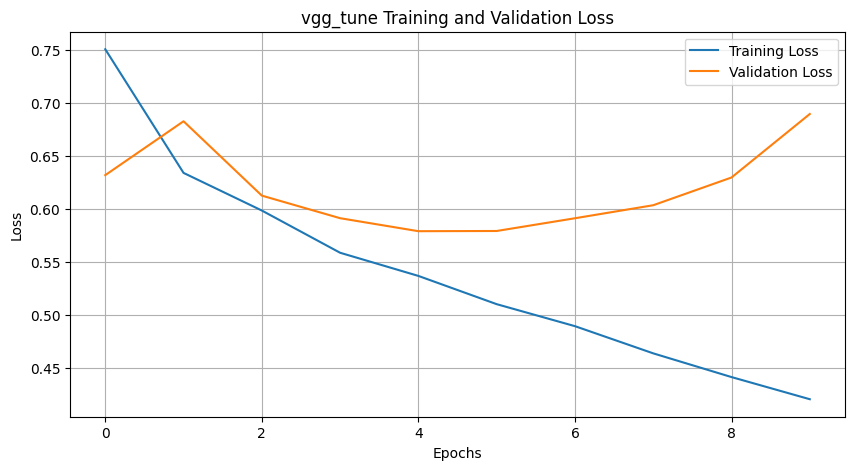

In [ ]:
plot_loss_curves('vgg_tune', '/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/vgg_freeze_train_metrics.csv')

### ResNet

In [ ]:
resnet_freeze_model,resnet_freeze_log = train_pretrained_model('resnet', data_loaders, freeze = True, total_epochs = 10, save_dir = save_log_dir)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 [Validation]: 100%|██████████| 34/34 [00:31<00:00,  1.07it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 1 - Train Loss: 0.6354, Train Acc: 0.75%, Valid Loss: 0.5725, Valid Acc: 0.78%


Epoch 2/10 [Validation]: 100%|██████████| 34/34 [00:31<00:00,  1.08it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 2 - Train Loss: 0.5164, Train Acc: 0.79%, Valid Loss: 0.6822, Valid Acc: 0.73%


Epoch 3/10 [Validation]: 100%|██████████| 34/34 [00:31<00:00,  1.09it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 3 - Train Loss: 0.4221, Train Acc: 0.83%, Valid Loss: 0.5805, Valid Acc: 0.76%


Epoch 4/10 [Validation]: 100%|██████████| 34/34 [00:30<00:00,  1.10it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 4 - Train Loss: 0.3173, Train Acc: 0.87%, Valid Loss: 0.7489, Valid Acc: 0.70%


Epoch 5/10 [Validation]: 100%|██████████| 34/34 [00:31<00:00,  1.09it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 5 - Train Loss: 0.2389, Train Acc: 0.90%, Valid Loss: 0.8008, Valid Acc: 0.77%


Epoch 6/10 [Validation]: 100%|██████████| 34/34 [00:29<00:00,  1.15it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 6 - Train Loss: 0.1749, Train Acc: 0.93%, Valid Loss: 1.3721, Valid Acc: 0.67%


Epoch 7/10 [Validation]: 100%|██████████| 34/34 [00:31<00:00,  1.10it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 7 - Train Loss: 0.1235, Train Acc: 0.95%, Valid Loss: 0.9801, Valid Acc: 0.73%


Epoch 8/10 [Validation]: 100%|██████████| 34/34 [00:31<00:00,  1.09it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 8 - Train Loss: 0.1019, Train Acc: 0.96%, Valid Loss: 1.0657, Valid Acc: 0.76%


Epoch 9/10 [Validation]: 100%|██████████| 34/34 [00:31<00:00,  1.09it/s]
<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 9 - Train Loss: 0.1011, Train Acc: 0.96%, Valid Loss: 0.9918, Valid Acc: 0.74%


Epoch 10/10 [Validation]: 100%|██████████| 34/34 [00:30<00:00,  1.11it/s]

Epoch 10 - Train Loss: 0.0670, Train Acc: 0.98%, Valid Loss: 1.1888, Valid Acc: 0.75%
Training completed. Metrics logged to /content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/resnet_freeze_train_metrics.csv.



<ipython-input-23-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


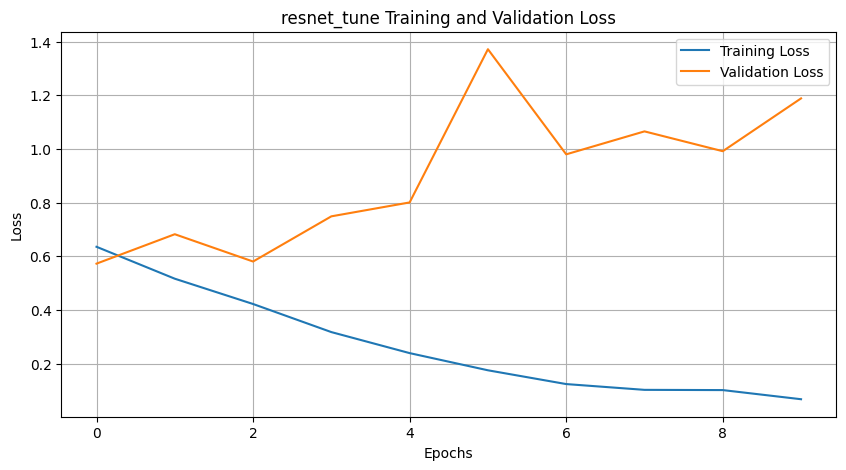

In [ ]:
# Example usage
plot_loss_curves('resnet_tune', '/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/resnet_freeze_train_metrics.csv')

### EfficientNet

In [ ]:
pip install --upgrade torch torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
efficientnet_freeze_model,efficientnet_freeze_log = train_pretrained_model('efficientnet', data_loaders, freeze = True, total_epochs = 50, save_dir = save_log_dir)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 72.0MB/s]
Epoch 1/50 [Validation]: 100%|██████████| 34/34 [12:57<00:00, 22.86s/it]
<ipython-input-19-41d9209ee667>:84: FutureWarning: The frame.append me

Epoch 1 - Train Loss: 2.5626, Train Acc: 0.46%, Valid Loss: 1.1089, Valid Acc: 0.67%


Epoch 2/50 [Validation]: 100%|██████████| 34/34 [07:26<00:00, 13.14s/it]
<ipython-input-19-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 2 - Train Loss: 1.0742, Train Acc: 0.66%, Valid Loss: 0.8809, Valid Acc: 0.70%


Epoch 3/50 [Validation]: 100%|██████████| 34/34 [07:22<00:00, 13.03s/it]
<ipython-input-19-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 3 - Train Loss: 0.9406, Train Acc: 0.69%, Valid Loss: 0.8132, Valid Acc: 0.72%


Epoch 4/50 [Validation]: 100%|██████████| 34/34 [07:08<00:00, 12.61s/it]
<ipython-input-19-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 4 - Train Loss: 0.8682, Train Acc: 0.70%, Valid Loss: 0.7729, Valid Acc: 0.72%


Epoch 5/50 [Training]:  43%|████▎     | 49/114 [14:09<19:01, 17.56s/it]

## Hyperparameter tuning

In [ ]:
def create_vgg_classifier(num_classes, dropout_rate):
    classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True),
        nn.Dropout(dropout_rate),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(dropout_rate),
        nn.Linear(4096, num_classes),
    )
    return classifier

### loss

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Assume num_classes, train_loader, and valid_loader are defined and loaded with your data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 3  # Replace with your actual number of classes
total_epochs = 100  # Set your total number of epochs
early_stopping_rounds = 3  # Set your number of rounds for early stopping


def objective(trial):
    # Hyperparameters to tune
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
    momentum = trial.suggest_uniform('momentum', 0.5, 0.99) if optimizer_name == "sgd" else 0.0

    # Create the classifier model
    classifier = create_vgg_classifier(num_classes, dropout_rate).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == "adam":
        optimizer = optim.Adam(classifier.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(classifier.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Early stopping setup
    best_loss = float('inf')
    best_classifier = None
    patience_counter = 0

    # Training and validation loop with early stopping
    for epoch in range(total_epochs):
        # Training loop
        classifier.train()
        train_loss = 0.0
        for inputs, labels in vgg_feature_loaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation loop
        classifier.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in vgg_feature_loaders['valid']:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = classifier(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

        avg_valid_loss = valid_loss/len(vgg_feature_loaders['valid'])

        # Early stopping condition
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            best_classifier = deepcopy(classifier)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_rounds:
                break

    return best_loss

# Create a study object and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

# Get the best hyperparameters
best_hyperparams = study.best_trial.params
print('Best hyperparameters:', best_hyperparams)


[I 2023-12-11 06:16:34,802] A new study created in memory with name: no-name-8de5dc46-416c-4fbb-b878-6c292caa2962
[W 2023-12-11 06:16:36,189] Trial 0 failed with parameters: {'optimizer': 'sgd', 'lr': 2.1329211828709486e-05, 'dropout_rate': 0.26444015131037246, 'weight_decay': 0.0008525526428925531, 'momentum': 0.6761900672909608} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-14-707480225c18>", line 20, in objective
    classifier = create_vgg_classifier(num_classes, dropout_rate).to(device)
  File "<ipython-input-12-bf9a23de3126>", line 3, in create_vgg_classifier
    nn.Linear(512 * 7 * 7, 4096),
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/linear.py", line 101, in __init__
    self.reset_parameters()
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lin

KeyboardInterrupt: ignored

In [ ]:
vgg_model,vgg_log = train_classifier('vgg_hyper', vgg_feature_loaders, total_epochs=20, num_classes=3, save_dir =save_log_dir,lr=4.6493835037812114e-05, weight_decay = 1.1201112273657975e-05,dropout_rate = 0.0320474304373229)

Epoch 1/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 217.12it/s]


Epoch 1 - Train Loss: 0.6533, Train Acc: 0.74%, Valid Loss: 0.6183, Valid Acc: 0.76%


Epoch 2/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 205.60it/s]


Epoch 2 - Train Loss: 0.5522, Train Acc: 0.77%, Valid Loss: 0.5951, Valid Acc: 0.77%


Epoch 3/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 221.28it/s]


Epoch 3 - Train Loss: 0.4730, Train Acc: 0.81%, Valid Loss: 0.6312, Valid Acc: 0.77%


Epoch 4/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 224.61it/s]


Epoch 4 - Train Loss: 0.3826, Train Acc: 0.84%, Valid Loss: 0.7142, Valid Acc: 0.76%


Epoch 5/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 193.37it/s]


Epoch 5 - Train Loss: 0.2812, Train Acc: 0.89%, Valid Loss: 0.7497, Valid Acc: 0.76%


Epoch 6/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 225.02it/s]


Epoch 6 - Train Loss: 0.1822, Train Acc: 0.93%, Valid Loss: 0.8916, Valid Acc: 0.74%


Epoch 7/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 226.35it/s]


Epoch 7 - Train Loss: 0.1251, Train Acc: 0.96%, Valid Loss: 1.0031, Valid Acc: 0.72%


Epoch 8/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 215.13it/s]


Epoch 8 - Train Loss: 0.0752, Train Acc: 0.97%, Valid Loss: 1.2343, Valid Acc: 0.74%


Epoch 9/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 197.39it/s]


Epoch 9 - Train Loss: 0.0375, Train Acc: 0.99%, Valid Loss: 1.3514, Valid Acc: 0.74%


Epoch 10/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 224.47it/s]


Epoch 10 - Train Loss: 0.0238, Train Acc: 0.99%, Valid Loss: 1.5886, Valid Acc: 0.75%


Epoch 11/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 221.68it/s]


Epoch 11 - Train Loss: 0.0284, Train Acc: 0.99%, Valid Loss: 1.4819, Valid Acc: 0.75%


Epoch 12/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 205.86it/s]


Epoch 12 - Train Loss: 0.0406, Train Acc: 0.99%, Valid Loss: 1.6637, Valid Acc: 0.66%


Epoch 13/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 226.90it/s]


Epoch 13 - Train Loss: 0.0449, Train Acc: 0.98%, Valid Loss: 1.4746, Valid Acc: 0.71%


Epoch 14/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 229.10it/s]


Epoch 14 - Train Loss: 0.0332, Train Acc: 0.99%, Valid Loss: 1.6317, Valid Acc: 0.74%


Epoch 15/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 197.38it/s]


Epoch 15 - Train Loss: 0.0200, Train Acc: 0.99%, Valid Loss: 1.6719, Valid Acc: 0.75%


Epoch 16/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 227.73it/s]


Epoch 16 - Train Loss: 0.0146, Train Acc: 0.99%, Valid Loss: 1.8036, Valid Acc: 0.71%


Epoch 17/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 224.61it/s]


Epoch 17 - Train Loss: 0.0197, Train Acc: 0.99%, Valid Loss: 1.7919, Valid Acc: 0.72%


Epoch 18/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 225.74it/s]


Epoch 18 - Train Loss: 0.0190, Train Acc: 0.99%, Valid Loss: 1.8765, Valid Acc: 0.74%


Epoch 19/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 201.17it/s]


Epoch 19 - Train Loss: 0.0581, Train Acc: 0.98%, Valid Loss: 1.5634, Valid Acc: 0.74%


Epoch 20/20 [Validation]: 100%|██████████| 67/67 [00:00<00:00, 224.42it/s]


Epoch 20 - Train Loss: 0.0048, Train Acc: 1.00%, Valid Loss: 1.8611, Valid Acc: 0.75%
Training completed. Metrics logged to /content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/vgg_hyper_try_metrics.csv.


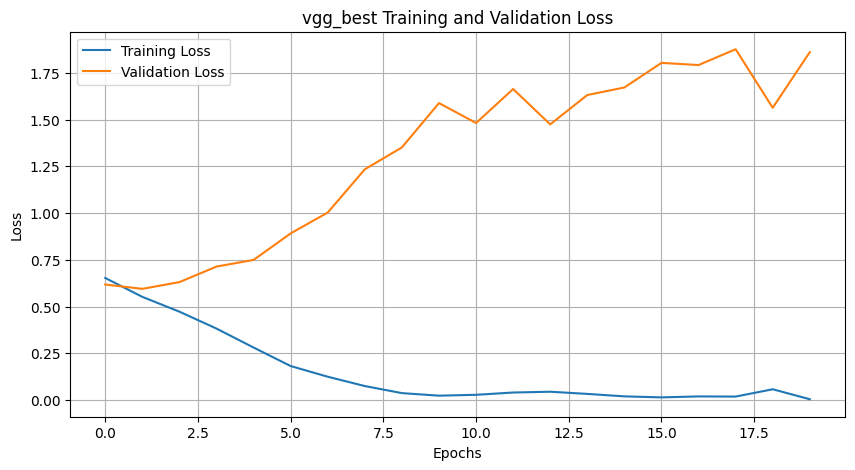

In [ ]:
plot_loss_curves('vgg_best', '/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/vgg_hyper_try_metrics.csv')

### SGD with lr_decay

In [ ]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Assume num_classes, train_loader, and valid_loader are defined and loaded with your data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 3  # Replace with your actual number of classes
total_epochs = 50  # Set your total number of epochs
early_stopping_rounds = 3  # Set your number of rounds for early stopping

In [ ]:
def objective2(trial):
    # Hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.8)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-3)
    momentum = trial.suggest_uniform('momentum', 0.5, 0.99)
    lr_decay_step = trial.suggest_int('lr_decay_step', 5, 15)
    lr_decay_gamma = trial.suggest_uniform('lr_decay_gamma', 0.1, 0.9)
    min_delta = trial.suggest_loguniform('min_delta', 1e-4, 1e-2)  # Minimum improvement threshold

    # Create the classifier model
    classifier = create_vgg_classifier(num_classes, dropout_rate).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(classifier.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)

    # Early stopping setup
    best_loss = float('inf')
    patience_counter = 0

    # Training and validation loop with early stopping
    for epoch in range(total_epochs):
        # Training loop
        classifier.train()
        train_loss = 0.0
        for inputs, labels in vgg_feature_loaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Step the learning rate scheduler
        lr_scheduler.step()

        # Validation loop
        classifier.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in vgg_feature_loaders['valid']:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = classifier(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

        avg_valid_loss = valid_loss / len(vgg_feature_loaders['valid'])

        # Check for improvement with min_delta threshold
        if avg_valid_loss < (best_loss - min_delta):
            best_loss = avg_valid_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_rounds:
                print(f"No improvement for {early_stopping_rounds} consecutive epochs, stopping early.")
                break

    return best_loss

In [ ]:
# Create a study object and optimize
study2 = optuna.create_study(direction='minimize')
study2.optimize(objective2, n_trials=100)

# Get the best hyperparameters
best_hyperparams2 = study2.best_trial.params
print('Best hyperparameters:', best_hyperparams2)

[I 2023-12-11 06:17:54,960] A new study created in memory with name: no-name-fd5fbf1d-e754-49cd-a07f-831b3bf4a872
[I 2023-12-11 06:21:52,027] Trial 0 finished with value: 0.6004084170754276 and parameters: {'lr': 0.00022261037291425038, 'dropout_rate': 0.512561420533932, 'weight_decay': 0.00023981524511291694, 'momentum': 0.8333710654802178, 'lr_decay_step': 12, 'lr_decay_gamma': 0.22754565492230006, 'min_delta': 0.0007101012001982587}. Best is trial 0 with value: 0.6004084170754276.


No improvement for 3 consecutive epochs, stopping early.


[I 2023-12-11 06:25:05,114] Trial 1 finished with value: 0.6338378515706133 and parameters: {'lr': 0.00011007837705701973, 'dropout_rate': 0.6059361891981968, 'weight_decay': 0.00012656536112260912, 'momentum': 0.8332913920808627, 'lr_decay_step': 5, 'lr_decay_gamma': 0.6918406617653755, 'min_delta': 0.0012576761122188036}. Best is trial 0 with value: 0.6004084170754276.


No improvement for 3 consecutive epochs, stopping early.


[I 2023-12-11 06:30:13,575] Trial 2 finished with value: 0.6175708468280622 and parameters: {'lr': 0.0001176780184306449, 'dropout_rate': 0.44561314390170315, 'weight_decay': 5.6670845193765884e-05, 'momentum': 0.678691613194323, 'lr_decay_step': 10, 'lr_decay_gamma': 0.8643620863872971, 'min_delta': 0.0023384542286676545}. Best is trial 0 with value: 0.6004084170754276.


No improvement for 3 consecutive epochs, stopping early.


[I 2023-12-11 06:30:56,923] Trial 3 finished with value: 0.6108770228143948 and parameters: {'lr': 0.0006237002212504267, 'dropout_rate': 0.3781661165828425, 'weight_decay': 0.0006598127572108755, 'momentum': 0.9815385745120216, 'lr_decay_step': 11, 'lr_decay_gamma': 0.6849674541709406, 'min_delta': 0.0026391803578483326}. Best is trial 0 with value: 0.6004084170754276.


No improvement for 3 consecutive epochs, stopping early.


[I 2023-12-11 06:34:43,206] Trial 4 finished with value: 0.745234999194074 and parameters: {'lr': 1.255187860236714e-05, 'dropout_rate': 0.3175165841262862, 'weight_decay': 0.00022683389723441493, 'momentum': 0.5896170301195891, 'lr_decay_step': 6, 'lr_decay_gamma': 0.3675441346496918, 'min_delta': 0.0001472037081871196}. Best is trial 0 with value: 0.6004084170754276.


No improvement for 3 consecutive epochs, stopping early.


[W 2023-12-11 06:35:54,947] Trial 5 failed with parameters: {'lr': 0.000950514697372699, 'dropout_rate': 0.788892377990725, 'weight_decay': 0.00011353816866787673, 'momentum': 0.7895610178124339, 'lr_decay_step': 13, 'lr_decay_gamma': 0.36818048726493835, 'min_delta': 0.0001762155689847153} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-18-87b2d7f8c639>", line 34, in objective2
    loss.backward()
  File "/usr/local/lib/python3.10/dist-packages/torch/_tensor.py", line 492, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py", line 251, in backward
    Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
KeyboardInterrupt
[W 2023-12-11 06:35:54,950] Trial 5 failed with value None.


KeyboardInterrupt: ignored

## Simplified VGG

In [ ]:
class SimplifiedVGG(nn.Module):
    def __init__(self, num_classes=3):
        super(SimplifiedVGG, self).__init__()
        # Convolutional layers - Very Simplified VGG structure
        self.features = nn.Sequential(
            # Block 1: 128 output channels, 224x224 -> 112x112
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2: 256 output channels, 112x112 -> 28x28
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4, stride=4),

            # Block 3: 512 output channels, 28x28 -> 7x7
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4, stride=4),

        )

        # Fully connected layers - Simplified classifier
        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the features into a vector
        x = self.classifier(x)
        return x

In [ ]:
pip install torchsummary

In [ ]:
from torchsummary import summary

In [ ]:
model = SimplifiedVGG(num_classes=3)

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 28, 28]               0
            Conv2d-7          [-1, 128, 28, 28]          73,856
              ReLU-8          [-1, 128, 28, 28]               0
         MaxPool2d-9            [-1, 128, 7, 7]               0
           Linear-10                 [-1, 1024]       6,423,552
             ReLU-11                 [-1, 1024]               0
          Dropout-12                 [-1, 1024]               0
           Linear-13                 [-1, 1024]       1,049,600
             ReLU-14                 [-

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay = 1e-4)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimplifiedVGG(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=1024, out_features=3, bias=True)
  )
)

In [ ]:
# Lists for storing metrics
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

# Training and Validation Loops
num_epochs = 10  # Define the number of epochs

# CSV file for storing metrics
csv_file_path = os.path.join(save_log_dir, 'vgg_simple_metrics.csv')

# Prepare DataFrame to store losses and accuracies
log_df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])

for epoch in range(num_epochs):
    # Initialize metrics
    train_loss, train_correct, train_total = 0.0, 0, 0
    valid_loss, valid_correct, valid_total = 0.0, 0, 0

    # Training Phase
    model.train()
    for inputs, labels in tqdm(data_loaders['train'], desc=f'Epoch {epoch+1}/{num_epochs} [Training]'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)
        train_total += labels.size(0)

    # Validation Phase
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(data_loaders['valid'], desc=f'Epoch {epoch+1}/{num_epochs} [Validation]'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            valid_correct += torch.sum(preds == labels.data)
            valid_total += labels.size(0)


    # Calculate average loss and accuracy
    avg_train_loss = train_loss / len(data_loaders['train'])
    avg_train_acc = train_correct.double() / train_total
    avg_valid_loss = valid_loss / len(data_loaders['valid'])
    avg_valid_acc = valid_correct.double() / valid_total

    # Print average losses for the epoch
    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {avg_valid_acc:.2f}%")

    # Append metrics to DataFrame
    log_df = log_df.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_accuracy': avg_train_acc.item(),
            'valid_loss': avg_valid_loss,
            'valid_accuracy': avg_valid_acc.item()
        }, ignore_index=True)

    # Save DataFrame to CSV file
    log_df.to_csv(csv_file_path, index=False)

Epoch 1/10 [Validation]: 100%|██████████| 67/67 [09:47<00:00,  8.77s/it]
<ipython-input-41-75b39588c1f4>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 1 - Train Loss: 0.7394, Train Acc: 0.72%, Valid Loss: 0.6973, Valid Acc: 0.74%


Epoch 2/10 [Validation]: 100%|██████████| 67/67 [00:32<00:00,  2.07it/s]
<ipython-input-41-75b39588c1f4>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 2 - Train Loss: 0.6847, Train Acc: 0.74%, Valid Loss: 0.6516, Valid Acc: 0.75%


Epoch 3/10 [Validation]: 100%|██████████| 67/67 [00:33<00:00,  2.01it/s]
<ipython-input-41-75b39588c1f4>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 3 - Train Loss: 0.6473, Train Acc: 0.75%, Valid Loss: 0.6238, Valid Acc: 0.76%


Epoch 4/10 [Validation]: 100%|██████████| 67/67 [00:32<00:00,  2.06it/s]
<ipython-input-41-75b39588c1f4>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 4 - Train Loss: 0.6125, Train Acc: 0.76%, Valid Loss: 0.6166, Valid Acc: 0.76%


Epoch 5/10 [Validation]: 100%|██████████| 67/67 [00:31<00:00,  2.14it/s]
<ipython-input-41-75b39588c1f4>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 5 - Train Loss: 0.5831, Train Acc: 0.76%, Valid Loss: 0.6040, Valid Acc: 0.76%


Epoch 6/10 [Validation]: 100%|██████████| 67/67 [00:34<00:00,  1.97it/s]
<ipython-input-41-75b39588c1f4>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 6 - Train Loss: 0.5484, Train Acc: 0.77%, Valid Loss: 0.5980, Valid Acc: 0.77%


Epoch 7/10 [Validation]: 100%|██████████| 67/67 [00:32<00:00,  2.05it/s]
<ipython-input-41-75b39588c1f4>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 7 - Train Loss: 0.5142, Train Acc: 0.79%, Valid Loss: 0.6132, Valid Acc: 0.75%


Epoch 8/10 [Validation]: 100%|██████████| 67/67 [00:31<00:00,  2.11it/s]
<ipython-input-41-75b39588c1f4>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 8 - Train Loss: 0.4724, Train Acc: 0.80%, Valid Loss: 0.6831, Valid Acc: 0.76%


Epoch 9/10 [Validation]: 100%|██████████| 67/67 [00:32<00:00,  2.07it/s]
<ipython-input-41-75b39588c1f4>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 9 - Train Loss: 0.4305, Train Acc: 0.82%, Valid Loss: 0.6574, Valid Acc: 0.74%


Epoch 10/10 [Validation]: 100%|██████████| 67/67 [00:47<00:00,  1.40it/s]

Epoch 10 - Train Loss: 0.3756, Train Acc: 0.84%, Valid Loss: 0.7639, Valid Acc: 0.75%



<ipython-input-41-75b39588c1f4>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


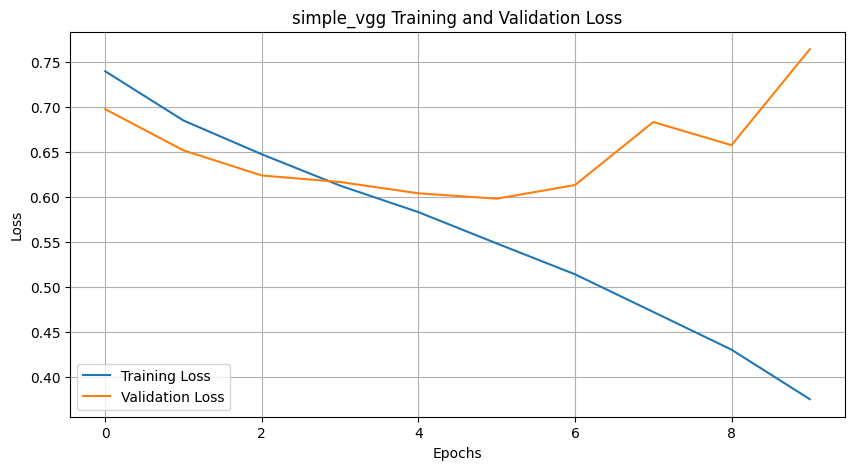

In [ ]:
plot_loss_curves('simple_vgg', '/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/newdata/vgg_simple_metrics.csv')

## Smaller balanced dataset

In [ ]:
# Get all 'Lower Quality' images
lower_quality_df = full_data_df[full_data_df['cut_group'] == 'Lower Quality']

# Correcting the number of samples to select from each quality group
num_samples_each_group = len(lower_quality_df)

# Randomly sample 'High Quality' and 'Medium Quality'
high_quality_df = full_data_df[full_data_df['cut_group'] == 'High Quality'].sample(n=num_samples_each_group)
medium_quality_df = full_data_df[full_data_df['cut_group'] == 'Medium Quality'].sample(n=num_samples_each_group)

# Combine them into a new dataframe
small_df = pd.concat([high_quality_df, medium_quality_df, lower_quality_df])

In [ ]:
small_df['cut_group'].value_counts()

High Quality      3262
Medium Quality    3262
Lower Quality     3262
Name: cut_group, dtype: int64

In [ ]:
#create small dataset

# Define the directory containing the images
root_dir = '/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/smalldata/'

# Split the data
train_df, test_df = train_test_split(small_df, test_size=0.3,stratify=small_df['cut_group'], random_state=249)
valid_df, test_df = train_test_split(test_df, test_size=1/3, stratify=test_df['cut_group'], random_state=249)  # 0.2 of the total data

# Create directories and move files
create_and_move_files(train_df, root_dir, 'train')
create_and_move_files(valid_df, root_dir, 'valid')
create_and_move_files(test_df, root_dir, 'test')

# Combine the dataframes back and save to a new CSV
combined_df = pd.concat([train_df, valid_df, test_df])
combined_df.to_csv('/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/smalldata/updated_diamond_data.csv', index=False)

Processing test: 100%|██████████| 979/979 [00:03<00:00, 292.41it/s]


In [ ]:
train_small_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/smalldata/train', transform=transform)
valid_small_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/smalldata/valid', transform=transform)
test_small_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/smalldata/test', transform=transform)

# Create DataLoaders
train_small_loader = DataLoader(train_small_dataset, batch_size=64, shuffle=True, num_workers=2)
valid_small_loader = DataLoader(valid_small_dataset, batch_size=64, shuffle=True, num_workers=2)
test_small_loader = DataLoader(test_small_dataset, batch_size=64, shuffle=False, num_workers=2)

data_small_loaders = {
    'train': train_small_loader,
    'valid': valid_small_loader,
    'test': test_small_loader
}

In [ ]:
print(len(data_small_loaders['train'].dataset))
print(len(data_small_loaders['valid'].dataset))
print(len(data_small_loaders['test'].dataset))

4112
1171
583


In [ ]:
# Train the classifier
small_log_dir = '/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/smalldata'

### Transfer VGG

In [ ]:
get_precomputed_features_loader('vgg', data_small_loaders, small_log_dir)
vgg_small_feature_loaders = load_saved_features('vgg',small_log_dir)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:19<00:00, 28.8MB/s]
Computing features for test set: 100%|██████████| 10/10 [01:44<00:00, 10.42s/it]


Features computed and saved to /content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/smalldata for model vgg


In [ ]:
vgg_small_model,vgg_small_log = train_classifier('vgg', vgg_small_feature_loaders, total_epochs=50, num_classes=3, save_dir =small_log_dir,lr=0.008, weight_decay = 1e-3,dropout_rate = 0.5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 110.25it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 1 - Train Loss: 71.1974, Train Acc: 0.35%, Valid Loss: 1.3492, Valid Acc: 0.34%


Epoch 2/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 108.64it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 2 - Train Loss: 2.2616, Train Acc: 0.34%, Valid Loss: 1.2320, Valid Acc: 0.39%


Epoch 3/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 103.01it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 3 - Train Loss: 1.3345, Train Acc: 0.37%, Valid Loss: 1.0957, Valid Acc: 0.37%


Epoch 4/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 109.77it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 4 - Train Loss: 1.3174, Train Acc: 0.36%, Valid Loss: 1.0995, Valid Acc: 0.37%


Epoch 5/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 112.86it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 5 - Train Loss: 1.4142, Train Acc: 0.38%, Valid Loss: 1.2568, Valid Acc: 0.32%


Epoch 6/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 112.63it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 6 - Train Loss: 1.5068, Train Acc: 0.35%, Valid Loss: 1.1007, Valid Acc: 0.32%


Epoch 7/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 106.20it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 7 - Train Loss: 1.3941, Train Acc: 0.36%, Valid Loss: 1.0977, Valid Acc: 0.36%


Epoch 8/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 107.67it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 8 - Train Loss: 1.6194, Train Acc: 0.37%, Valid Loss: 1.1144, Valid Acc: 0.32%


Epoch 9/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 111.88it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 9 - Train Loss: 1.3640, Train Acc: 0.36%, Valid Loss: 1.0980, Valid Acc: 0.36%


Epoch 10/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 110.17it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 10 - Train Loss: 1.3319, Train Acc: 0.37%, Valid Loss: 1.0972, Valid Acc: 0.40%


Epoch 11/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 106.98it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 11 - Train Loss: 1.2957, Train Acc: 0.37%, Valid Loss: 1.1826, Valid Acc: 0.40%


Epoch 12/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 106.22it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 12 - Train Loss: 1.4536, Train Acc: 0.36%, Valid Loss: 1.0968, Valid Acc: 0.36%


Epoch 13/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 92.18it/s] 
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 13 - Train Loss: 1.5375, Train Acc: 0.35%, Valid Loss: 1.0978, Valid Acc: 0.37%


Epoch 14/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 112.81it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 14 - Train Loss: 1.4961, Train Acc: 0.34%, Valid Loss: 1.2257, Valid Acc: 0.36%


Epoch 15/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 111.64it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 15 - Train Loss: 1.4612, Train Acc: 0.35%, Valid Loss: 1.1036, Valid Acc: 0.36%


Epoch 16/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 93.54it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 16 - Train Loss: 2.7301, Train Acc: 0.36%, Valid Loss: 1.1044, Valid Acc: 0.32%


Epoch 17/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 110.54it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 17 - Train Loss: 1.8388, Train Acc: 0.37%, Valid Loss: 1.1554, Valid Acc: 0.31%


Epoch 18/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 114.18it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 18 - Train Loss: 1.6041, Train Acc: 0.36%, Valid Loss: 1.1022, Valid Acc: 0.36%


Epoch 19/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 112.85it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 19 - Train Loss: 1.6822, Train Acc: 0.35%, Valid Loss: 1.3497, Valid Acc: 0.37%


Epoch 20/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 108.64it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 20 - Train Loss: 1.4738, Train Acc: 0.36%, Valid Loss: 1.0839, Valid Acc: 0.38%


Epoch 21/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 105.23it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 21 - Train Loss: 1.9966, Train Acc: 0.34%, Valid Loss: 1.4907, Valid Acc: 0.32%


Epoch 22/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 111.68it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 22 - Train Loss: 9.1516, Train Acc: 0.35%, Valid Loss: 1.3952, Valid Acc: 0.40%


Epoch 23/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 109.69it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 23 - Train Loss: 2.4317, Train Acc: 0.35%, Valid Loss: 1.2736, Valid Acc: 0.31%


Epoch 24/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 108.77it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 24 - Train Loss: 1.6077, Train Acc: 0.35%, Valid Loss: 1.2309, Valid Acc: 0.31%


Epoch 25/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 102.94it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 25 - Train Loss: 1.9361, Train Acc: 0.35%, Valid Loss: 1.1644, Valid Acc: 0.36%


Epoch 26/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 113.58it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 26 - Train Loss: 2.4464, Train Acc: 0.35%, Valid Loss: 1.2184, Valid Acc: 0.40%


Epoch 27/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 111.63it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 27 - Train Loss: 1.9965, Train Acc: 0.36%, Valid Loss: 11.4138, Valid Acc: 0.32%


Epoch 28/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 98.94it/s] 
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 28 - Train Loss: 2.1068, Train Acc: 0.36%, Valid Loss: 1.1271, Valid Acc: 0.36%


Epoch 29/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 100.52it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 29 - Train Loss: 1.9342, Train Acc: 0.34%, Valid Loss: 1.0889, Valid Acc: 0.40%


Epoch 30/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 97.78it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 30 - Train Loss: 2.1913, Train Acc: 0.35%, Valid Loss: 1.0980, Valid Acc: 0.36%


Epoch 31/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 112.43it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 31 - Train Loss: 2.2073, Train Acc: 0.34%, Valid Loss: 1.1392, Valid Acc: 0.31%


Epoch 32/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 106.52it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 32 - Train Loss: 3.3633, Train Acc: 0.35%, Valid Loss: 2.1774, Valid Acc: 0.30%


Epoch 33/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 105.96it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 33 - Train Loss: 3.6263, Train Acc: 0.35%, Valid Loss: 1.6109, Valid Acc: 0.36%


Epoch 34/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 109.12it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 34 - Train Loss: 1.9871, Train Acc: 0.35%, Valid Loss: 1.1015, Valid Acc: 0.32%


Epoch 35/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 114.72it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 35 - Train Loss: 1.6927, Train Acc: 0.37%, Valid Loss: 1.0959, Valid Acc: 0.36%


Epoch 36/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 111.98it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 36 - Train Loss: 1.8082, Train Acc: 0.34%, Valid Loss: 1.0990, Valid Acc: 0.37%


Epoch 37/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 102.67it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 37 - Train Loss: 4.1850, Train Acc: 0.35%, Valid Loss: 1.7342, Valid Acc: 0.36%


Epoch 38/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 94.09it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 38 - Train Loss: 2.3564, Train Acc: 0.35%, Valid Loss: 1.2632, Valid Acc: 0.36%


Epoch 39/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 51.12it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 39 - Train Loss: 2.4083, Train Acc: 0.35%, Valid Loss: 1.1476, Valid Acc: 0.40%


Epoch 40/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 33.25it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 40 - Train Loss: 1.8315, Train Acc: 0.36%, Valid Loss: 1.1336, Valid Acc: 0.38%


Epoch 41/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 105.98it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 41 - Train Loss: 2.4165, Train Acc: 0.33%, Valid Loss: 3.7905, Valid Acc: 0.32%


Epoch 42/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 101.05it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 42 - Train Loss: 3.0452, Train Acc: 0.35%, Valid Loss: 1.4931, Valid Acc: 0.36%


Epoch 43/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 63.47it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 43 - Train Loss: 2.0232, Train Acc: 0.36%, Valid Loss: 3.0450, Valid Acc: 0.34%


Epoch 44/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 105.65it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 44 - Train Loss: 3.0719, Train Acc: 0.36%, Valid Loss: 1.2325, Valid Acc: 0.36%


Epoch 45/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 108.18it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 45 - Train Loss: 1.6216, Train Acc: 0.36%, Valid Loss: 1.8354, Valid Acc: 0.36%


Epoch 46/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 114.83it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 46 - Train Loss: 3.1880, Train Acc: 0.37%, Valid Loss: 1.1190, Valid Acc: 0.36%


Epoch 47/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 113.09it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 47 - Train Loss: 2.9756, Train Acc: 0.36%, Valid Loss: 1.1002, Valid Acc: 0.32%


Epoch 48/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 105.19it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 48 - Train Loss: 1.6890, Train Acc: 0.35%, Valid Loss: 12.8206, Valid Acc: 0.32%


Epoch 49/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 104.52it/s]
<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 49 - Train Loss: 3.2734, Train Acc: 0.36%, Valid Loss: 1.5896, Valid Acc: 0.33%


Epoch 50/50 [Validation]: 100%|██████████| 19/19 [00:00<00:00, 112.49it/s]

Epoch 50 - Train Loss: 1.9250, Train Acc: 0.35%, Valid Loss: 1.7277, Valid Acc: 0.30%
Training completed. Metrics logged to /content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/smalldata/vgg_try_metrics.csv.



<ipython-input-82-c96445e8c432>:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


In [ ]:
vgg_small_freeze_model,vgg_small_freeze_log = train_pretrained_model('vgg', data_small_loaders, freeze = True, total_epochs = 20, save_dir = small_log_dir)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/20 [Validation]: 100%|██████████| 19/19 [00:12<00:00,  1.54it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 1 - Train Loss: 1.1457, Train Acc: 0.42%, Valid Loss: 0.9893, Valid Acc: 0.48%


Epoch 2/20 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.76it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 2 - Train Loss: 0.9624, Train Acc: 0.52%, Valid Loss: 0.9028, Valid Acc: 0.56%


Epoch 3/20 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  1.95it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 3 - Train Loss: 0.8934, Train Acc: 0.57%, Valid Loss: 0.8770, Valid Acc: 0.56%


Epoch 4/20 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.84it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 4 - Train Loss: 0.8072, Train Acc: 0.62%, Valid Loss: 0.9036, Valid Acc: 0.53%


Epoch 5/20 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.69it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 5 - Train Loss: 0.7227, Train Acc: 0.66%, Valid Loss: 0.9280, Valid Acc: 0.54%


Epoch 6/20 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.59it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 6 - Train Loss: 0.6545, Train Acc: 0.71%, Valid Loss: 1.0323, Valid Acc: 0.58%


Epoch 7/20 [Validation]: 100%|██████████| 19/19 [00:12<00:00,  1.55it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 7 - Train Loss: 0.5865, Train Acc: 0.74%, Valid Loss: 0.9863, Valid Acc: 0.56%


Epoch 8/20 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.68it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 8 - Train Loss: 0.5233, Train Acc: 0.77%, Valid Loss: 1.0602, Valid Acc: 0.56%


Epoch 9/20 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 9 - Train Loss: 0.4712, Train Acc: 0.80%, Valid Loss: 1.0282, Valid Acc: 0.56%


Epoch 10/20 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 10 - Train Loss: 0.4337, Train Acc: 0.81%, Valid Loss: 1.1538, Valid Acc: 0.57%


Epoch 11/20 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.75it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 11 - Train Loss: 0.3719, Train Acc: 0.85%, Valid Loss: 1.0190, Valid Acc: 0.58%


Epoch 12/20 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 12 - Train Loss: 0.3292, Train Acc: 0.87%, Valid Loss: 1.1898, Valid Acc: 0.58%


Epoch 13/20 [Validation]: 100%|██████████| 19/19 [00:12<00:00,  1.58it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 13 - Train Loss: 0.3035, Train Acc: 0.88%, Valid Loss: 1.3192, Valid Acc: 0.56%


Epoch 14/20 [Validation]: 100%|██████████| 19/19 [00:12<00:00,  1.58it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 14 - Train Loss: 0.3129, Train Acc: 0.88%, Valid Loss: 1.2519, Valid Acc: 0.55%


Epoch 15/20 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.80it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 15 - Train Loss: 0.2694, Train Acc: 0.89%, Valid Loss: 1.3815, Valid Acc: 0.58%


Epoch 16/20 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  1.98it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 16 - Train Loss: 0.2673, Train Acc: 0.90%, Valid Loss: 1.3907, Valid Acc: 0.58%


Epoch 17/20 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.78it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 17 - Train Loss: 0.2290, Train Acc: 0.91%, Valid Loss: 1.2979, Valid Acc: 0.60%


Epoch 18/20 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.62it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 18 - Train Loss: 0.2468, Train Acc: 0.90%, Valid Loss: 1.3229, Valid Acc: 0.58%


Epoch 19/20 [Validation]: 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 19 - Train Loss: 0.2062, Train Acc: 0.92%, Valid Loss: 1.4983, Valid Acc: 0.56%


Epoch 20/20 [Validation]: 100%|██████████| 19/19 [00:12<00:00,  1.55it/s]

Epoch 20 - Train Loss: 0.2080, Train Acc: 0.92%, Valid Loss: 1.4980, Valid Acc: 0.58%
Training completed. Metrics logged to /content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/smalldata/vgg_freeze_train_metrics.csv.



<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


In [ ]:
vgg_small_full_model,vgg_small_full_log = train_pretrained_model('vgg', data_small_loaders, freeze = False, total_epochs = 20, save_dir = small_log_dir)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/20 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 1 - Train Loss: 1.1318, Train Acc: 0.35%, Valid Loss: 1.1042, Valid Acc: 0.32%


Epoch 2/20 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  1.93it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 2 - Train Loss: 1.1003, Train Acc: 0.36%, Valid Loss: 1.1123, Valid Acc: 0.36%


Epoch 3/20 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.68it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 3 - Train Loss: 1.0957, Train Acc: 0.37%, Valid Loss: 1.0911, Valid Acc: 0.37%


Epoch 4/20 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.60it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 4 - Train Loss: 1.0651, Train Acc: 0.42%, Valid Loss: 1.0437, Valid Acc: 0.42%


Epoch 5/20 [Validation]: 100%|██████████| 19/19 [00:13<00:00,  1.44it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 5 - Train Loss: 1.0578, Train Acc: 0.40%, Valid Loss: 0.9961, Valid Acc: 0.45%


Epoch 6/20 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.62it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 6 - Train Loss: 1.0189, Train Acc: 0.46%, Valid Loss: 0.9879, Valid Acc: 0.47%


Epoch 7/20 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.75it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 7 - Train Loss: 0.9707, Train Acc: 0.49%, Valid Loss: 0.9708, Valid Acc: 0.51%


Epoch 8/20 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.86it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 8 - Train Loss: 0.9464, Train Acc: 0.52%, Valid Loss: 0.9917, Valid Acc: 0.48%


Epoch 9/20 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  2.00it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 9 - Train Loss: 0.9853, Train Acc: 0.49%, Valid Loss: 1.0187, Valid Acc: 0.45%


Epoch 10/20 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.78it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 10 - Train Loss: 0.9685, Train Acc: 0.51%, Valid Loss: 1.0543, Valid Acc: 0.51%


Epoch 11/20 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.68it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 11 - Train Loss: 0.9161, Train Acc: 0.54%, Valid Loss: 0.9896, Valid Acc: 0.50%


Epoch 12/20 [Validation]: 100%|██████████| 19/19 [00:12<00:00,  1.57it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 12 - Train Loss: 0.8998, Train Acc: 0.55%, Valid Loss: 0.9626, Valid Acc: 0.53%


Epoch 13/20 [Validation]: 100%|██████████| 19/19 [00:12<00:00,  1.55it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 13 - Train Loss: 0.8502, Train Acc: 0.59%, Valid Loss: 0.9507, Valid Acc: 0.53%


Epoch 14/20 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.67it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 14 - Train Loss: 0.7979, Train Acc: 0.63%, Valid Loss: 0.9609, Valid Acc: 0.54%


Epoch 15/20 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  1.92it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 15 - Train Loss: 0.7511, Train Acc: 0.65%, Valid Loss: 1.0929, Valid Acc: 0.50%


Epoch 16/20 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 16 - Train Loss: 0.6674, Train Acc: 0.70%, Valid Loss: 1.0853, Valid Acc: 0.53%


Epoch 17/20 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 17 - Train Loss: 0.6202, Train Acc: 0.72%, Valid Loss: 1.2070, Valid Acc: 0.50%


Epoch 18/20 [Validation]: 100%|██████████| 19/19 [00:12<00:00,  1.54it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 18 - Train Loss: 0.5255, Train Acc: 0.77%, Valid Loss: 1.2411, Valid Acc: 0.50%


Epoch 19/20 [Validation]: 100%|██████████| 19/19 [00:12<00:00,  1.58it/s]
<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 19 - Train Loss: 0.4380, Train Acc: 0.82%, Valid Loss: 1.3667, Valid Acc: 0.51%


Epoch 20/20 [Validation]: 100%|██████████| 19/19 [00:12<00:00,  1.58it/s]

Epoch 20 - Train Loss: 0.3533, Train Acc: 0.86%, Valid Loss: 1.6530, Valid Acc: 0.52%
Training completed. Metrics logged to /content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/smalldata/vgg_full_train_metrics.csv.



<ipython-input-85-41d9209ee667>:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


### Simple VGG

In [ ]:
model = SimplifiedVGG(num_classes=3)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay = 1e-4)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimplifiedVGG(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=1024, out_features=3, bias=True)
  )
)

In [ ]:
# Lists for storing metrics
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

# Training and Validation Loops
num_epochs = 100  # Define the number of epochs

# CSV file for storing metrics
csv_file_path = os.path.join(small_log_dir, 'vgg_simple_metrics.csv')

# Prepare DataFrame to store losses and accuracies
log_df = pd.DataFrame(columns=['epoch', 'train_loss', 'train_accuracy', 'valid_loss', 'valid_accuracy'])

for epoch in range(num_epochs):
    # Initialize metrics
    train_loss, train_correct, train_total = 0.0, 0, 0
    valid_loss, valid_correct, valid_total = 0.0, 0, 0

    # Training Phase
    model.train()
    for inputs, labels in tqdm(data_small_loaders['train'], desc=f'Epoch {epoch+1}/{num_epochs} [Training]'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)
        train_total += labels.size(0)

    # Validation Phase
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(data_small_loaders['valid'], desc=f'Epoch {epoch+1}/{num_epochs} [Validation]'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            valid_correct += torch.sum(preds == labels.data)
            valid_total += labels.size(0)


    # Calculate average loss and accuracy
    avg_train_loss = train_loss / len(data_loaders['train'])
    avg_train_acc = train_correct.double() / train_total
    avg_valid_loss = valid_loss / len(data_loaders['valid'])
    avg_valid_acc = valid_correct.double() / valid_total

    # Print average losses for the epoch
    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {avg_valid_acc:.2f}%")

    # Append metrics to DataFrame
    log_df = log_df.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_accuracy': avg_train_acc.item(),
            'valid_loss': avg_valid_loss,
            'valid_accuracy': avg_valid_acc.item()
        }, ignore_index=True)

    # Save DataFrame to CSV file
    log_df.to_csv(csv_file_path, index=False)

Epoch 1/100 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.68it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 1 - Train Loss: 0.2696, Train Acc: 0.52%, Valid Loss: 0.2730, Valid Acc: 0.50%


Epoch 2/100 [Validation]: 100%|██████████| 19/19 [00:08<00:00,  2.27it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 2 - Train Loss: 0.2556, Train Acc: 0.55%, Valid Loss: 0.2662, Valid Acc: 0.53%


Epoch 3/100 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.70it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 3 - Train Loss: 0.2402, Train Acc: 0.59%, Valid Loss: 0.2680, Valid Acc: 0.54%


Epoch 4/100 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.67it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 4 - Train Loss: 0.2224, Train Acc: 0.64%, Valid Loss: 0.2774, Valid Acc: 0.52%


Epoch 5/100 [Validation]: 100%|██████████| 19/19 [00:08<00:00,  2.29it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 5 - Train Loss: 0.2043, Train Acc: 0.67%, Valid Loss: 0.2984, Valid Acc: 0.53%


Epoch 6/100 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.68it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 6 - Train Loss: 0.1818, Train Acc: 0.72%, Valid Loss: 0.2935, Valid Acc: 0.53%


Epoch 7/100 [Validation]: 100%|██████████| 19/19 [00:12<00:00,  1.51it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 7 - Train Loss: 0.1608, Train Acc: 0.76%, Valid Loss: 0.3259, Valid Acc: 0.50%


Epoch 8/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  1.96it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 8 - Train Loss: 0.1355, Train Acc: 0.80%, Valid Loss: 0.3541, Valid Acc: 0.49%


Epoch 9/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  2.07it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 9 - Train Loss: 0.1102, Train Acc: 0.84%, Valid Loss: 0.4078, Valid Acc: 0.52%


Epoch 10/100 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.67it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 10 - Train Loss: 0.0839, Train Acc: 0.88%, Valid Loss: 0.4560, Valid Acc: 0.52%


Epoch 11/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  2.00it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 11 - Train Loss: 0.0681, Train Acc: 0.91%, Valid Loss: 0.4891, Valid Acc: 0.51%


Epoch 12/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  2.04it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 12 - Train Loss: 0.0620, Train Acc: 0.92%, Valid Loss: 0.5308, Valid Acc: 0.51%


Epoch 13/100 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 13 - Train Loss: 0.0441, Train Acc: 0.94%, Valid Loss: 0.5618, Valid Acc: 0.52%


Epoch 14/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  1.95it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 14 - Train Loss: 0.0428, Train Acc: 0.95%, Valid Loss: 0.5879, Valid Acc: 0.51%


Epoch 15/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 15 - Train Loss: 0.0416, Train Acc: 0.94%, Valid Loss: 0.6157, Valid Acc: 0.51%


Epoch 16/100 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.66it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 16 - Train Loss: 0.0280, Train Acc: 0.96%, Valid Loss: 0.6815, Valid Acc: 0.50%


Epoch 17/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  1.94it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 17 - Train Loss: 0.0241, Train Acc: 0.97%, Valid Loss: 0.7027, Valid Acc: 0.50%


Epoch 18/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 18 - Train Loss: 0.0246, Train Acc: 0.97%, Valid Loss: 0.7658, Valid Acc: 0.51%


Epoch 19/100 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.65it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 19 - Train Loss: 0.0222, Train Acc: 0.97%, Valid Loss: 0.7449, Valid Acc: 0.52%


Epoch 20/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  2.04it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 20 - Train Loss: 0.0206, Train Acc: 0.97%, Valid Loss: 0.7111, Valid Acc: 0.51%


Epoch 21/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  1.98it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 21 - Train Loss: 0.0243, Train Acc: 0.97%, Valid Loss: 0.7256, Valid Acc: 0.51%


Epoch 22/100 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.66it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 22 - Train Loss: 0.0205, Train Acc: 0.97%, Valid Loss: 0.7883, Valid Acc: 0.53%


Epoch 23/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  2.08it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 23 - Train Loss: 0.0206, Train Acc: 0.97%, Valid Loss: 0.7541, Valid Acc: 0.51%


Epoch 24/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  1.96it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 24 - Train Loss: 0.0198, Train Acc: 0.98%, Valid Loss: 0.7801, Valid Acc: 0.54%


Epoch 25/100 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.67it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 25 - Train Loss: 0.0192, Train Acc: 0.97%, Valid Loss: 0.9097, Valid Acc: 0.49%


Epoch 26/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  2.03it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 26 - Train Loss: 0.0189, Train Acc: 0.97%, Valid Loss: 0.8062, Valid Acc: 0.52%


Epoch 27/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  2.04it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 27 - Train Loss: 0.0195, Train Acc: 0.98%, Valid Loss: 0.8289, Valid Acc: 0.51%


Epoch 28/100 [Training]:  11%|█         | 7/65 [00:04<00:40,  1.45it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e29939b9ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e29939b9ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py",

Epoch 28 - Train Loss: 0.0173, Train Acc: 0.98%, Valid Loss: 0.7676, Valid Acc: 0.54%


Epoch 29/100 [Training]:  63%|██████▎   | 41/65 [00:21<00:12,  1.97it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e29939b9ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e29939b9ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py"

Epoch 29 - Train Loss: 0.0173, Train Acc: 0.98%, Valid Loss: 0.7746, Valid Acc: 0.52%


Epoch 30/100 [Training]:   0%|          | 0/65 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e29939b9ea0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e29939b9ea0>    
assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
AssertionError    : c

Epoch 30 - Train Loss: 0.0143, Train Acc: 0.98%, Valid Loss: 0.8090, Valid Acc: 0.51%


Epoch 31/100 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.72it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 31 - Train Loss: 0.0149, Train Acc: 0.98%, Valid Loss: 0.7960, Valid Acc: 0.52%


Epoch 32/100 [Validation]: 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 32 - Train Loss: 0.0112, Train Acc: 0.99%, Valid Loss: 0.8404, Valid Acc: 0.52%


Epoch 33/100 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.84it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 33 - Train Loss: 0.0119, Train Acc: 0.99%, Valid Loss: 0.9321, Valid Acc: 0.51%


Epoch 34/100 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.70it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 34 - Train Loss: 0.0094, Train Acc: 0.99%, Valid Loss: 0.8747, Valid Acc: 0.51%


Epoch 35/100 [Validation]: 100%|██████████| 19/19 [00:08<00:00,  2.35it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 35 - Train Loss: 0.0131, Train Acc: 0.98%, Valid Loss: 0.8817, Valid Acc: 0.52%


Epoch 36/100 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.69it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 36 - Train Loss: 0.0207, Train Acc: 0.97%, Valid Loss: 0.7213, Valid Acc: 0.51%


Epoch 37/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  2.10it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 37 - Train Loss: 0.0125, Train Acc: 0.99%, Valid Loss: 0.8174, Valid Acc: 0.51%


Epoch 38/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  1.97it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 38 - Train Loss: 0.0122, Train Acc: 0.99%, Valid Loss: 0.7569, Valid Acc: 0.51%


Epoch 39/100 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.74it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 39 - Train Loss: 0.0080, Train Acc: 0.99%, Valid Loss: 0.7932, Valid Acc: 0.52%


Epoch 40/100 [Validation]: 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 40 - Train Loss: 0.0091, Train Acc: 0.99%, Valid Loss: 0.7985, Valid Acc: 0.52%


Epoch 41/100 [Validation]: 100%|██████████| 19/19 [00:11<00:00,  1.73it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 41 - Train Loss: 0.0116, Train Acc: 0.99%, Valid Loss: 0.8390, Valid Acc: 0.52%


Epoch 42/100 [Validation]: 100%|██████████| 19/19 [00:07<00:00,  2.46it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 42 - Train Loss: 0.0066, Train Acc: 0.99%, Valid Loss: 0.8792, Valid Acc: 0.52%


Epoch 43/100 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.77it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 43 - Train Loss: 0.0106, Train Acc: 0.99%, Valid Loss: 0.8682, Valid Acc: 0.52%


Epoch 44/100 [Validation]: 100%|██████████| 19/19 [00:08<00:00,  2.32it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 44 - Train Loss: 0.0132, Train Acc: 0.99%, Valid Loss: 0.9126, Valid Acc: 0.50%


Epoch 45/100 [Validation]: 100%|██████████| 19/19 [00:08<00:00,  2.26it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 45 - Train Loss: 0.0147, Train Acc: 0.98%, Valid Loss: 0.8887, Valid Acc: 0.50%


Epoch 46/100 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.85it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 46 - Train Loss: 0.0134, Train Acc: 0.98%, Valid Loss: 0.7812, Valid Acc: 0.52%


Epoch 47/100 [Validation]: 100%|██████████| 19/19 [00:07<00:00,  2.63it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 47 - Train Loss: 0.0126, Train Acc: 0.99%, Valid Loss: 0.8216, Valid Acc: 0.51%


Epoch 48/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  2.03it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 48 - Train Loss: 0.0136, Train Acc: 0.99%, Valid Loss: 0.8611, Valid Acc: 0.52%


Epoch 49/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  2.05it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 49 - Train Loss: 0.0153, Train Acc: 0.98%, Valid Loss: 0.8117, Valid Acc: 0.52%


Epoch 50/100 [Validation]: 100%|██████████| 19/19 [00:07<00:00,  2.60it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 50 - Train Loss: 0.0124, Train Acc: 0.98%, Valid Loss: 0.8438, Valid Acc: 0.52%


Epoch 51/100 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.87it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 51 - Train Loss: 0.0166, Train Acc: 0.98%, Valid Loss: 0.8707, Valid Acc: 0.50%


Epoch 52/100 [Validation]: 100%|██████████| 19/19 [00:08<00:00,  2.37it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 52 - Train Loss: 0.0103, Train Acc: 0.99%, Valid Loss: 0.8929, Valid Acc: 0.51%


Epoch 53/100 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.79it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 53 - Train Loss: 0.0097, Train Acc: 0.99%, Valid Loss: 0.8497, Valid Acc: 0.52%


Epoch 54/100 [Validation]: 100%|██████████| 19/19 [00:07<00:00,  2.43it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 54 - Train Loss: 0.0100, Train Acc: 0.99%, Valid Loss: 0.8365, Valid Acc: 0.49%


Epoch 55/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  2.05it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 55 - Train Loss: 0.0064, Train Acc: 0.99%, Valid Loss: 0.8785, Valid Acc: 0.52%


Epoch 56/100 [Validation]: 100%|██████████| 19/19 [00:09<00:00,  2.02it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 56 - Train Loss: 0.0095, Train Acc: 0.99%, Valid Loss: 0.9119, Valid Acc: 0.50%


Epoch 57/100 [Validation]: 100%|██████████| 19/19 [00:07<00:00,  2.58it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 57 - Train Loss: 0.0092, Train Acc: 0.99%, Valid Loss: 0.8665, Valid Acc: 0.51%


Epoch 58/100 [Validation]: 100%|██████████| 19/19 [00:10<00:00,  1.86it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 58 - Train Loss: 0.0108, Train Acc: 0.99%, Valid Loss: 0.8731, Valid Acc: 0.51%


Epoch 59/100 [Validation]: 100%|██████████| 19/19 [00:08<00:00,  2.32it/s]
<ipython-input-69-ee925d3eb84d>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  log_df = log_df.append({


Epoch 59 - Train Loss: 0.0158, Train Acc: 0.98%, Valid Loss: 0.7867, Valid Acc: 0.51%


Epoch 60/100 [Validation]:  74%|███████▎  | 14/19 [00:07<00:02,  1.87it/s]


OSError: ignored

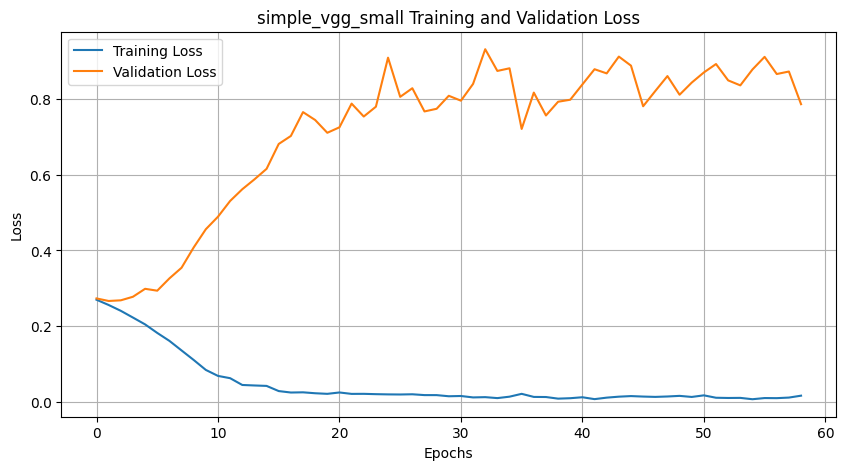

In [ ]:
plot_loss_curves('simple_vgg_small', '/content/drive/MyDrive/Duke/Fall 2/Modern Analytics/Final Project/smalldata/vgg_simple_metrics.csv')

# Performance evaluation

In [ ]:
vgg_test_loader = load_test_features('vgg',save_model_dir)

In [ ]:
# Assuming you have a model, test_loader, and device (CPU/GPU)
vgg_model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in vgg_test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = vgg_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, np.argmax(all_preds, axis=1))

In [ ]:
print(accuracy)

0.7473784556720686


In [ ]:
# Binarize labels for PR curve calculation
num_classes = 3  # Set the number of classes
all_labels_bin = label_binarize(all_labels, classes=range(num_classes))
all_preds = np.array(all_preds)

# Compute PR curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(all_labels_bin[:, i], all_preds[:, i])
    average_precision[i] = average_precision_score(all_labels_bin[:, i], all_preds[:, i])

# Compute micro-average PR curve and average precision
precision["micro"], recall["micro"], _ = precision_recall_curve(all_labels_bin.ravel(), all_preds.ravel())
average_precision["micro"] = average_precision_score(all_labels_bin, all_preds, average="micro")

In [ ]:
len(all_labels)

2098

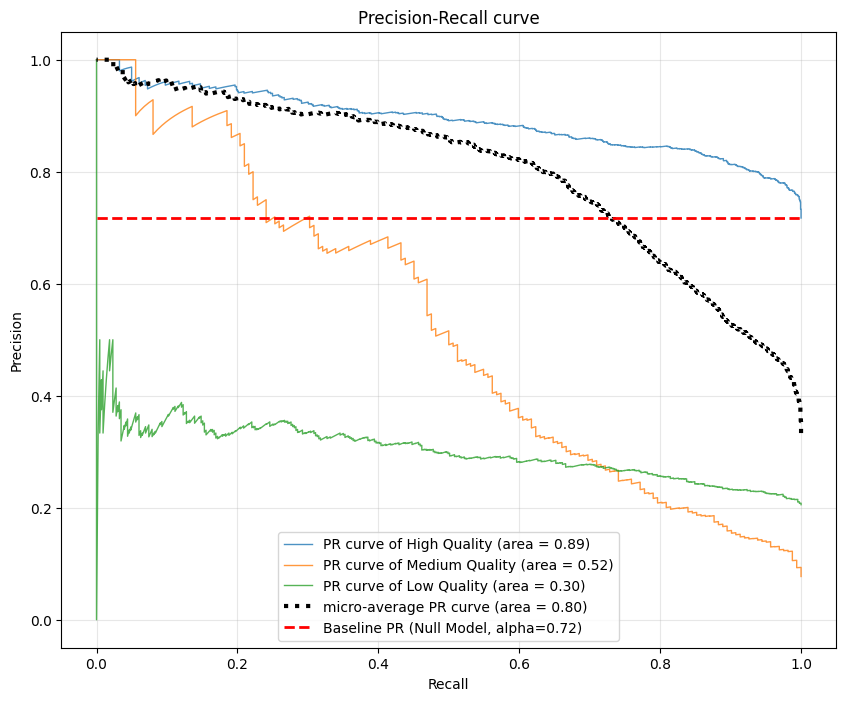

In [ ]:
class_names = ['High Quality', 'Medium Quality', 'Low Quality']

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], lw=1, alpha = 0.8, label='PR curve of {0} (area = {1:0.2f})'.format(class_names[i], average_precision[i]))
plt.plot(recall['micro'], precision['micro'], color='black', lw=3, linestyle=':', label='micro-average PR curve (area = {0:0.2f})'.format(average_precision['micro']))

positive_class_proportion = all_labels.count(0) / len(all_labels)
plt.hlines(positive_class_proportion, 0, 1, colors='red', linestyles='dashed', lw=2, label=f'Baseline PR (Null Model, alpha={positive_class_proportion:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="best")
plt.grid(alpha=0.3)

plt.show()

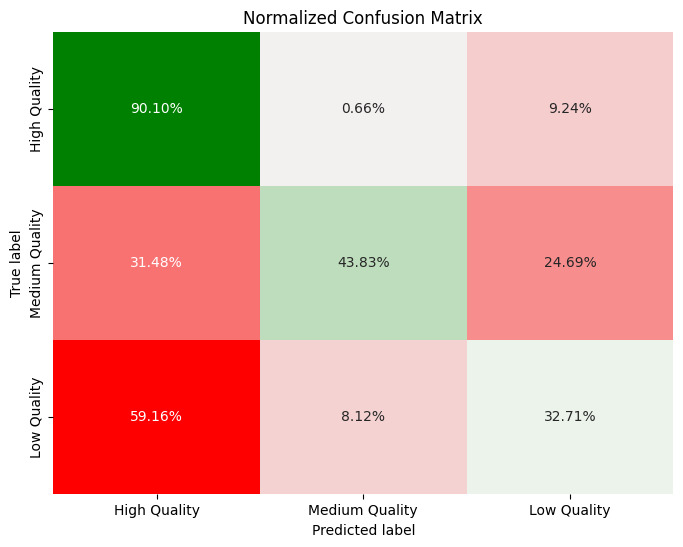

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(all_labels, np.argmax(all_preds, axis=1))

# Normalize the confusion matrix by row
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create masks for correct and incorrect predictions
correct_mask = np.eye(cm_normalized.shape[0], dtype=bool)
incorrect_mask = ~correct_mask

# Define the color map for correct and incorrect predictions
cmap_correct = sns.light_palette("green", as_cmap=True)
cmap_incorrect = sns.light_palette("red", as_cmap=True)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the incorrect predictions
sns.heatmap(cm_normalized, mask=correct_mask, annot=True, fmt='.2%', cmap=cmap_incorrect, xticklabels=class_names, yticklabels=class_names, cbar=False, ax=ax)
# Overlay the correct predictions on top
sns.heatmap(cm_normalized, mask=incorrect_mask, annot=True, fmt='.2%', cmap=cmap_correct, xticklabels=class_names, yticklabels=class_names, cbar=False, ax=ax)

ax.set_title('Normalized Confusion Matrix')
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
plt.show()